# IMPORT 

In [87]:
import time
import locale
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


## DATA UNDERSTANDING 


In [2]:
df = pd.read_csv("bandara.csv", sep=";")
df.head()

actualdate domestik / inter arrival / departure  pesawat  total pax  \
0  01/01/2019                D                   A      175      21374   
1  01/01/2019                D                   D      179      18895   
2  01/01/2019                I                   A       25       4911   
3  01/01/2019                I                   D       22       3294   
4  02/01/2019                D                   A      189      22941   

   transit  bagasi (kg)  kargo (kg)  
0        0       170749       74197  
1     2057       171158       85784  
2        0        85776       14122  
3        0        34764        8856  
4        0       191315       50209

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8543 entries, 0 to 8542
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   actualdate           8543 non-null   object
 1   domestik / inter     8543 non-null   object
 2   arrival / departure  8543 non-null   object
 3   pesawat              8543 non-null   int64 
 4   total pax            8543 non-null   int64 
 5   transit              8543 non-null   int64 
 6   bagasi (kg)          8543 non-null   int64 
 7   kargo (kg)           8543 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 534.1+ KB


In [4]:
df["actualdate"] = pd.to_datetime(df["actualdate"], dayfirst=True)


In [5]:
df["domestik / inter"] = (df["domestik / inter"].astype(str).str.strip().str.upper().str[0])

In [6]:
df_rekap = (
    df.groupby(["actualdate", "domestik / inter"])
      .agg({
          "pesawat": "sum",
          "total pax": "sum",
          "transit": "sum",
          "bagasi (kg)": "sum",
          "kargo (kg)": "sum"
      })
      .unstack("domestik / inter")
)

In [7]:
df_rekap.columns = [f"{m}_{d}" for m, d in df_rekap.columns]
df_rekap = df_rekap.reset_index().sort_values("actualdate")

In [8]:
for c in df_rekap.columns:
    if c != "actualdate":
        df_rekap[c] = df_rekap[c].fillna(0).astype(int)

In [9]:
df_rekap.sample(5)

actualdate  pesawat_D  pesawat_I  total pax_D  total pax_I  transit_D  \
1685 2023-08-13        223         40        31394         6711       2298   
1485 2023-01-25        213         30        27925         6070       2028   
1641 2023-06-30        221         30        29120         4867       2288   
2156 2024-11-26        182         37        21230         6941       1290   
1049 2021-11-15        173          2        19956            0       2171   

      transit_I  bagasi (kg)_D  bagasi (kg)_I  kargo (kg)_D  kargo (kg)_I  
1685          0         250465          83930        152398         32936  
1485          0         196938          84962        148223         27508  
1641          0         251137          62431        108725         41075  
2156          0         160486         111768        160778         52066  
1049          0         150263              0        119294         26341

In [10]:
df_rekap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   actualdate     2192 non-null   datetime64[ns]
 1   pesawat_D      2192 non-null   int32         
 2   pesawat_I      2192 non-null   int32         
 3   total pax_D    2192 non-null   int32         
 4   total pax_I    2192 non-null   int32         
 5   transit_D      2192 non-null   int32         
 6   transit_I      2192 non-null   int32         
 7   bagasi (kg)_D  2192 non-null   int32         
 8   bagasi (kg)_I  2192 non-null   int32         
 9   kargo (kg)_D   2192 non-null   int32         
 10  kargo (kg)_I   2192 non-null   int32         
dtypes: datetime64[ns](1), int32(10)
memory usage: 102.9 KB


In [11]:

df_rekap = df_rekap.rename(columns={
    "penumpang_domestik": "penumpang_D",
    "penumpang_international": "penumpang_I",
    "actualdate": "tanggal"
    })


In [12]:
df_rekap

tanggal  pesawat_D  pesawat_I  total pax_D  total pax_I  transit_D  \
0    2019-01-01        354         47        40269         8205       2057   
1    2019-01-02        376         45        43837         7684       2587   
2    2019-01-03        342         50        40886         9002       2695   
3    2019-01-04        352         43        40812         6915       2908   
4    2019-01-05        351         46        40041         6723       2810   
...         ...        ...        ...          ...          ...        ...   
2187 2024-12-27        233         36        30089         5971       1240   
2188 2024-12-28        247         36        31565         6011       1389   
2189 2024-12-29        237         35        33994         6229       1403   
2190 2024-12-30        231         38        29074         7352       1308   
2191 2024-12-31        173         38        21979         6185        869   

      transit_I  bagasi (kg)_D  bagasi (kg)_I  kargo (kg)_D  kargo (kg)_I  
0             0         341907         120540        159981         22978  
1             0         382068         115786        117203         30201  
2             0         360797         150109        229180         49094  
3             0         340421          93097        293485         58664  
4             0         376136          90955        288927         71415  
...         ...            ...            ...           ...           ...  
2187          0         243204          85021        181608         60409  
2188          0         258305          81965        220166         62230  
2189          0         271028          94091        184851         41213  
2190          0         232463         107190        146732         56095  
2191          0         168899          99676        140919         46260  

[2192 rows x 11 columns]

In [13]:
df_rekap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tanggal        2192 non-null   datetime64[ns]
 1   pesawat_D      2192 non-null   int32         
 2   pesawat_I      2192 non-null   int32         
 3   total pax_D    2192 non-null   int32         
 4   total pax_I    2192 non-null   int32         
 5   transit_D      2192 non-null   int32         
 6   transit_I      2192 non-null   int32         
 7   bagasi (kg)_D  2192 non-null   int32         
 8   bagasi (kg)_I  2192 non-null   int32         
 9   kargo (kg)_D   2192 non-null   int32         
 10  kargo (kg)_I   2192 non-null   int32         
dtypes: datetime64[ns](1), int32(10)
memory usage: 102.9 KB


In [14]:
locale.setlocale(locale.LC_TIME, "id_ID.UTF-8")
df_rekap["hari"] = df_rekap["tanggal"].dt.strftime("%A")
df_rekap.head()

tanggal  pesawat_D  pesawat_I  total pax_D  total pax_I  transit_D  \
0 2019-01-01        354         47        40269         8205       2057   
1 2019-01-02        376         45        43837         7684       2587   
2 2019-01-03        342         50        40886         9002       2695   
3 2019-01-04        352         43        40812         6915       2908   
4 2019-01-05        351         46        40041         6723       2810   

   transit_I  bagasi (kg)_D  bagasi (kg)_I  kargo (kg)_D  kargo (kg)_I    hari  
0          0         341907         120540        159981         22978  Selasa  
1          0         382068         115786        117203         30201    Rabu  
2          0         360797         150109        229180         49094   Kamis  
3          0         340421          93097        293485         58664   Jumat  
4          0         376136          90955        288927         71415   Sabtu

## ANALISIS PESAWAT 

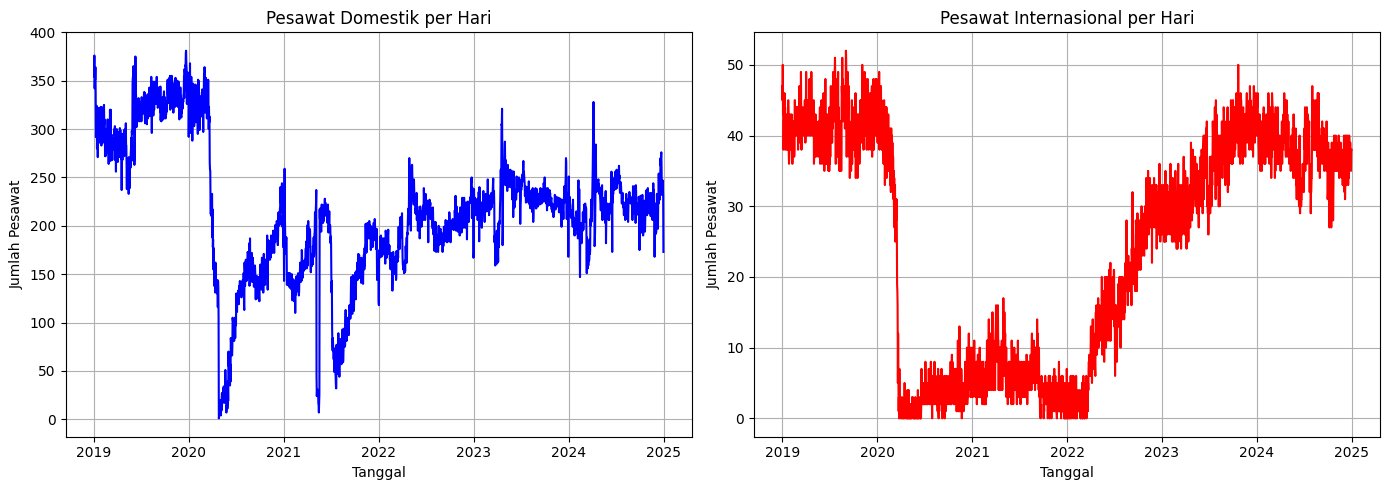

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharex=True)
axes[0].plot(df_rekap["tanggal"], df_rekap["pesawat_D"], color="blue")
axes[0].set_title("Pesawat Domestik per Hari")
axes[0].set_ylabel("Jumlah Pesawat")
axes[0].set_xlabel("Tanggal")
axes[0].grid(True)

axes[1].plot(df_rekap["tanggal"], df_rekap["pesawat_I"], color="red")
axes[1].set_title("Pesawat Internasional per Hari")
axes[1].set_ylabel("Jumlah Pesawat")
axes[1].set_xlabel("Tanggal")
axes[1].grid(True)

plt.tight_layout()
plt.show()


# ✈️ Insight Jumlah Pesawat Harian (2019–2024)

## 🟦 Penerbangan Domestik
- **2019** → Stabil tinggi di kisaran **300–350 flight/hari**.
- **2020** → Terjadi **penurunan drastis** (pandemi COVID-19), bahkan sempat mendekati **nol**.
- **2021** → Mulai **rebound**, namun masih **fluktuatif**.
- **2022** → Pemulihan lebih konsisten (**150–220 flight/hari**).
- **2023–2024** → Stabil di kisaran **200–250 flight/hari**, **belum kembali ke level 2019**.

## 🟥 Penerbangan Internasional
- **2019** → Stabil di kisaran **40–50 flight/hari**.
- **2020–2021** → Hampir berhenti total (**<10 flight/hari**).
- **2022** → Awal **pemulihan**, naik perlahan.
- **2023–2024** → Stabil kembali di **30–40 flight/hari**, **masih di bawah level 2019**.

## 📌 Insight Utama
- **Domestik pulih lebih cepat** dibanding internasional.
- **Internasional butuh ±2 tahun lebih lama** untuk mencapai kestabilan.
- **2019 = baseline tertinggi** sebelum pandemi.
- Lonjakan musiman (mudik/akhir tahun) jelas terlihat pada penerbangan domestik.


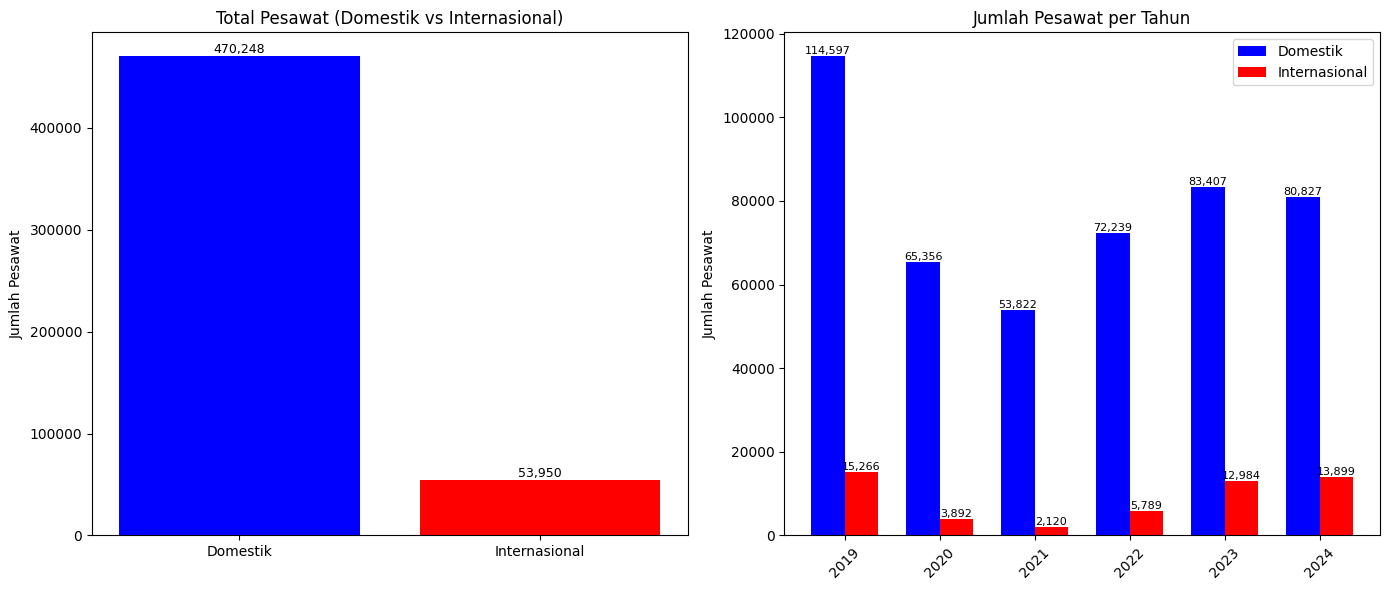

In [16]:

total_domestik = df_rekap["pesawat_D"].sum()
total_internasional = df_rekap["pesawat_I"].sum()

df_rekap["tahun"] = df_rekap["tanggal"].dt.year
per_tahun = df_rekap.groupby("tahun")[["pesawat_D", "pesawat_I"]].sum()

fig, axes = plt.subplots(1, 2, figsize=(14,6))

axes[0].bar(["Domestik", "Internasional"], [total_domestik, total_internasional], color=["blue","red"])
axes[0].set_title("Total Pesawat (Domestik vs Internasional)")
axes[0].set_ylabel("Jumlah Pesawat")

for i, val in enumerate([total_domestik, total_internasional]):
    axes[0].text(i, val, f"{val:,}", ha="center", va="bottom", fontsize=9)

width = 0.35
x = range(len(per_tahun.index))
axes[1].bar([i - width/2 for i in x], per_tahun["pesawat_D"], width, label="Domestik", color="blue")
axes[1].bar([i + width/2 for i in x], per_tahun["pesawat_I"], width, label="Internasional", color="red")
axes[1].set_xticks(x)
axes[1].set_xticklabels(per_tahun.index, rotation=45)
axes[1].set_title("Jumlah Pesawat per Tahun")
axes[1].set_ylabel("Jumlah Pesawat")
axes[1].legend()

for i, year in enumerate(per_tahun.index):
    axes[1].text(i - width/2, per_tahun["pesawat_D"].iloc[i], f"{per_tahun['pesawat_D'].iloc[i]:,}", 
                 ha="center", va="bottom", fontsize=8)
    axes[1].text(i + width/2, per_tahun["pesawat_I"].iloc[i], f"{per_tahun['pesawat_I'].iloc[i]:,}", 
                 ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


# 📊 Insight Jumlah Pesawat (2019–2024)

## 🔹 Total (Domestik vs Internasional)
- **Domestik**: 470.248 flight  
- **Internasional**: 53.950 flight  
👉 Kontribusi domestik **~90%+** dari total penerbangan → Bandara Juanda lebih berperan sebagai **hub domestik**.

---

## 🔹 Per Tahun
### 🟦 Domestik
- **2019** → 114.597 (baseline tertinggi, pra-pandemi).  
- **2020** → 65.356 (turun drastis karena COVID-19).  
- **2021** → 53.822 (terendah sepanjang periode).  
- **2022** → 72.239 (awal pemulihan).  
- **2023** → 83.407 (pemulihan kuat).  
- **2024** → 80.827 (stabil, belum setara 2019).

### 🟥 Internasional
- **2019** → 15.266 (normal pra-pandemi).  
- **2020** → 3.892 (jatuh >70%).  
- **2021** → 2.120 (terendah, hampir lumpuh).  
- **2022** → 5.789 (mulai bangkit).  
- **2023** → 12.984 (pemulihan signifikan).  
- **2024** → 13.899 (mendekati angka 2019, hampir pulih penuh).

---

## 📌 Insight Utama
- **Domestik pulih lebih cepat**: rebound mulai 2022, stabil >80 ribu flight per tahun.  
- **Internasional tertinggal**: baru mendekati level 2019 pada 2024.  
- **Pukulan terparah di 2021**, terutama internasional.  
- Tren menunjukkan **2023–2024 sebagai fase konsolidasi pemulihan**.  


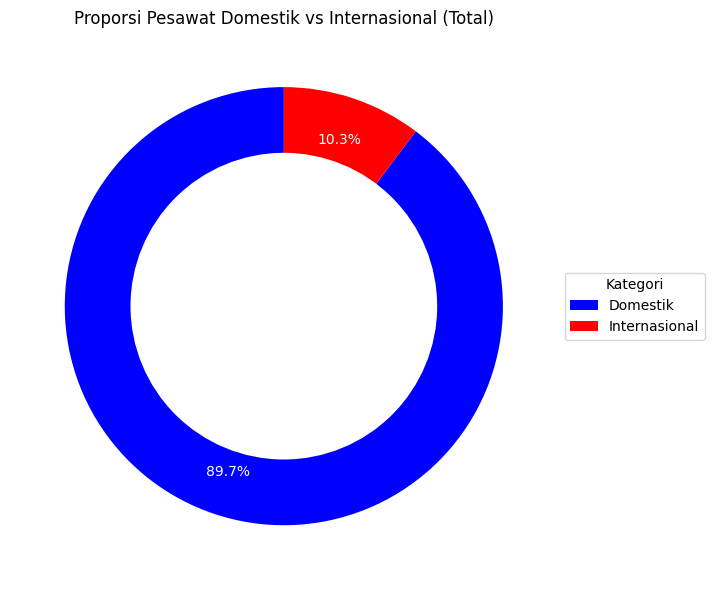

In [17]:
total_domestik = df_rekap["pesawat_D"].sum()
total_internasional = df_rekap["pesawat_I"].sum()

# Data untuk chart
labels = ["Domestik", "Internasional"]
values = [total_domestik, total_internasional]
colors = ["blue", "red"]

# Plot Donut Chart
plt.figure(figsize=(7,6))
wedges, texts, autotexts = plt.pie(
    values, autopct="%1.1f%%", startangle=90, colors=colors,
    textprops=dict(color="white"), pctdistance=0.8
)

# Tambahkan lubang di tengah (biar jadi donut)
centre_circle = plt.Circle((0,0),0.70,fc="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Tambahkan legend
plt.legend(wedges, labels, title="Kategori", loc="center left", bbox_to_anchor=(1,0,0.5,1))

plt.title("Proporsi Pesawat Domestik vs Internasional (Total)")
plt.tight_layout()
plt.show()


#  Proporsi Pesawat Domestik vs Internasional (2019–2024)

## 🔹 Proporsi Total
- **Domestik**: 89,7%  
- **Internasional**: 10,3%  

## 📌 Insight
- **Domestik sangat dominan** → hampir 9 dari 10 penerbangan di Juanda adalah domestik.  
- Peran **internasional masih kecil**, meski mulai pulih setelah pandemi.  
- Potensi strategi pengembangan → **perluasan rute internasional** agar tidak terlalu bergantung pada pasar domestik.  


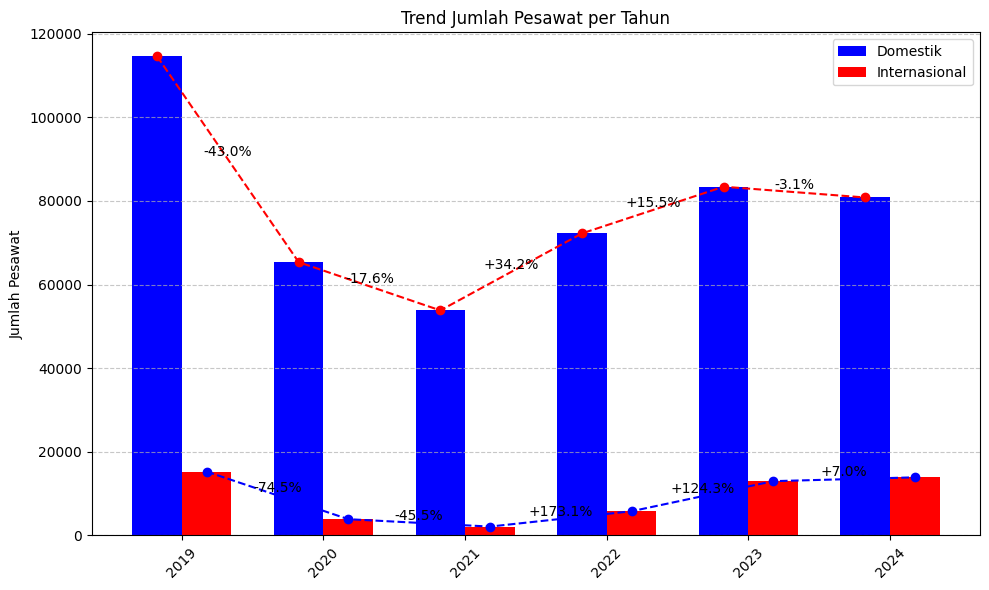

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(per_tahun.index))
width = 0.35

bars1 = ax.bar(x - width/2, per_tahun["pesawat_D"], width, label="Domestik", color="blue")
bars2 = ax.bar(x + width/2, per_tahun["pesawat_I"], width, label="Internasional", color="red")

ax.plot(x - width/2, per_tahun["pesawat_D"], color="red", marker="o", linestyle="--")
for i in range(1, len(per_tahun)):
    prev = per_tahun["pesawat_D"].iloc[i-1]
    curr = per_tahun["pesawat_D"].iloc[i]
    pct = (curr - prev) / prev * 100 if prev != 0 else 0
    ax.text((x[i-1] - width/2 + x[i] - width/2)/2, (prev + curr)/2,
            f"{pct:+.1f}%", color="black", ha="center", va="bottom")

ax.plot(x + width/2, per_tahun["pesawat_I"], color="blue", marker="o", linestyle="--")
for i in range(1, len(per_tahun)):
    prev = per_tahun["pesawat_I"].iloc[i-1]
    curr = per_tahun["pesawat_I"].iloc[i]
    pct = (curr - prev) / prev * 100 if prev != 0 else 0
    ax.text((x[i-1] + width/2 + x[i] + width/2)/2, (prev + curr)/2,
            f"{pct:+.1f}%", color="black", ha="center", va="bottom")

ax.set_xticks(x)
ax.set_xticklabels(per_tahun.index, rotation=45)
ax.set_ylabel("Jumlah Pesawat")
ax.set_title("Trend Jumlah Pesawat per Tahun")
ax.legend()
ax.grid(True, axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


# 📊 Tren Jumlah Pesawat per Tahun (2019–2024)

## 🟦 Domestik
- **2019 → 2020**: turun **-43%** (COVID-19).
- **2020 → 2021**: turun lagi **-17,6%**, titik terendah.
- **2021 → 2022**: rebound **+34,2%**.
- **2022 → 2023**: naik **+15,5%** (fase pemulihan).
- **2023 → 2024**: sedikit turun **-3,1%**, cenderung stabil.

## 🟥 Internasional
- **2019 → 2020**: jatuh **-74,5%**, paling terdampak pandemi.
- **2020 → 2021**: turun lagi **-45,5%**, titik nadir.
- **2021 → 2022**: lonjakan **+173,1%**, tanda re-opening.
- **2022 → 2023**: tumbuh **+124,3%**, pemulihan besar.
- **2023 → 2024**: naik lagi **+7%**, mendekati kondisi normal.

---

## 📌 Insight Utama
- **Domestik**: lebih tahan krisis, pemulihan cepat, tapi 2024 masih di bawah level 2019.  
- **Internasional**: sangat terdampak pandemi, namun **pemulihan lebih agresif** sejak 2022.  
- **2023–2024**: fase konsolidasi, tren mendekati stabil.  


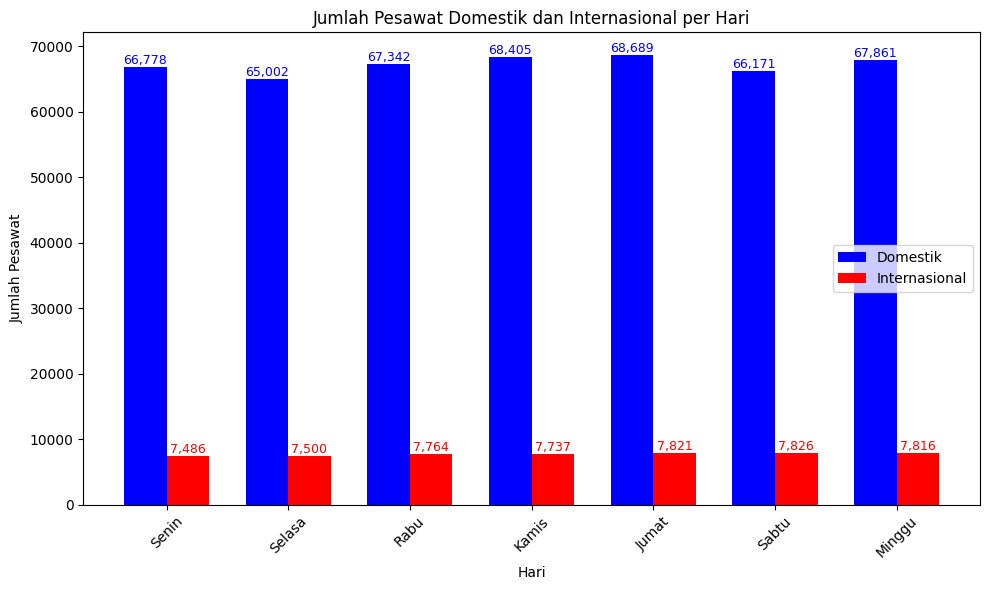

In [19]:
rekap_hari = df_rekap.groupby("hari")[["pesawat_D", "pesawat_I"]].sum()
urut_hari = ["Senin", "Selasa", "Rabu", "Kamis", "Jumat", "Sabtu", "Minggu"]
rekap_hari = rekap_hari.reindex(urut_hari)

x = np.arange(len(rekap_hari.index))
width = 0.35

plt.figure(figsize=(10,6))

bars1 = plt.bar(x - width/2, rekap_hari["pesawat_D"], width, label="Domestik", color="blue")
bars2 = plt.bar(x + width/2, rekap_hari["pesawat_I"], width, label="Internasional", color="red")

for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:,}", 
             ha="center", va="bottom", fontsize=9, color="blue")

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:,}", 
             ha="center", va="bottom", fontsize=9, color="red")

plt.title("Jumlah Pesawat Domestik dan Internasional per Hari")
plt.xlabel("Hari")
plt.ylabel("Jumlah Pesawat")
plt.xticks(x, rekap_hari.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# 📅 Pola Jumlah Pesawat per Hari (Domestik & Internasional)

## 🟦 Domestik
- **Terendah**: Selasa (**65.002 flight**).
- **Tertinggi**: Minggu (**67.861 flight**), disusul Jumat–Sabtu.
- Pola cenderung stabil, dengan **peningkatan menjelang akhir pekan**.

## 🟥 Internasional
- **Terendah**: Senin (**7.486 flight**).
- **Tertinggi**: Sabtu (**7.826 flight**) dan Minggu (**7.816 flight**).
- Pola juga stabil, dengan **puncak di akhir pekan**.

---

## 📌 Insight Utama
- **Weekend effect** terlihat jelas → penerbangan domestik & internasional sama-sama meningkat pada **Sabtu–Minggu**.
- **Domestik** tetap dominan dengan rasio hampir **9:1** dibanding internasional.
- **Hari kerja (Senin–Selasa)** relatif lebih rendah → kemungkinan karena perjalanan bisnis lebih terbatas dibanding arus wisata/rekreasi di akhir pekan.


In [20]:
df_rekap["nama_bulan"] = df_rekap["tanggal"].dt.month_name()

df_rekap["nama_bulan"] = df_rekap["nama_bulan"].replace({
    "January": "Januari", "February": "Februari", "March": "Maret",
    "April": "April", "May": "Mei", "June": "Juni",
    "July": "Juli", "August": "Agustus", "September": "September",
    "October": "Oktober", "November": "November", "December": "Desember"
})


In [21]:
df_rekap.head()

tanggal  pesawat_D  pesawat_I  total pax_D  total pax_I  transit_D  \
0 2019-01-01        354         47        40269         8205       2057   
1 2019-01-02        376         45        43837         7684       2587   
2 2019-01-03        342         50        40886         9002       2695   
3 2019-01-04        352         43        40812         6915       2908   
4 2019-01-05        351         46        40041         6723       2810   

   transit_I  bagasi (kg)_D  bagasi (kg)_I  kargo (kg)_D  kargo (kg)_I  \
0          0         341907         120540        159981         22978   
1          0         382068         115786        117203         30201   
2          0         360797         150109        229180         49094   
3          0         340421          93097        293485         58664   
4          0         376136          90955        288927         71415   

     hari  tahun nama_bulan  
0  Selasa   2019    Januari  
1    Rabu   2019    Januari  
2   Kamis   2019    Januari  
3   Jumat   2019    Januari  
4   Sabtu   2019    Januari

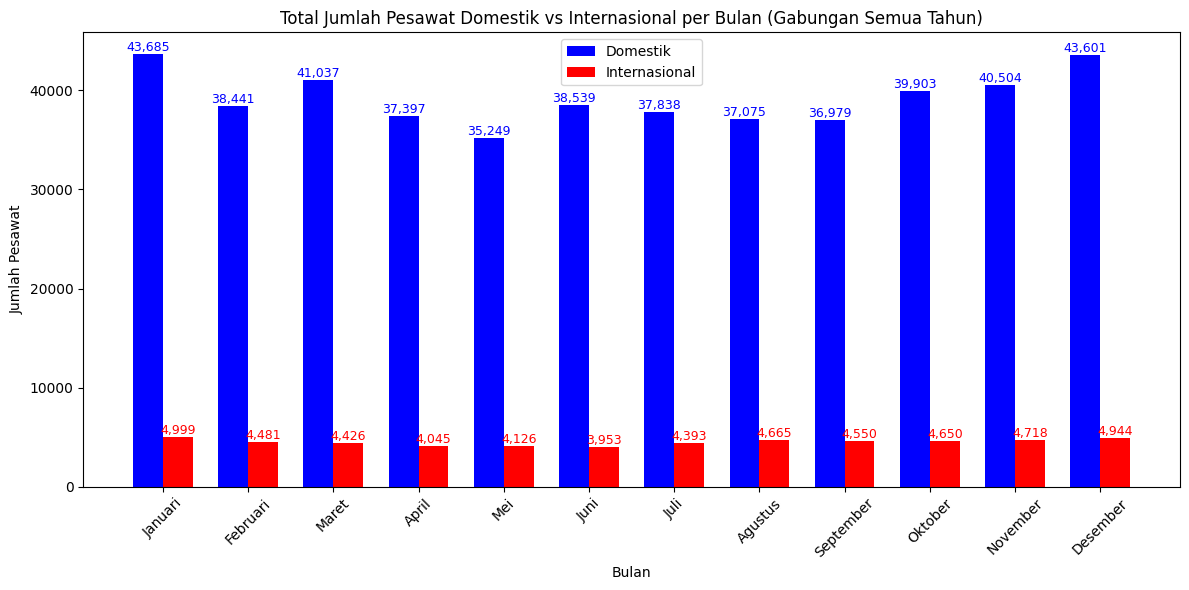

In [22]:
rekap_bulan_total = df_rekap.groupby("nama_bulan")[["pesawat_D","pesawat_I"]].sum().reset_index()

# Urutan bulan manual
urutan_bulan = ["Januari","Februari","Maret","April","Mei","Juni",
                "Juli","Agustus","September","Oktober","November","Desember"]

# Sort sesuai urutan bulan
rekap_bulan_total["nama_bulan"] = pd.Categorical(rekap_bulan_total["nama_bulan"], categories=urutan_bulan, ordered=True)
rekap_bulan_total = rekap_bulan_total.sort_values("nama_bulan")

# Plot
x = np.arange(len(rekap_bulan_total))
width = 0.35

plt.figure(figsize=(12,6))
bars1 = plt.bar(x - width/2, rekap_bulan_total["pesawat_D"], width, label="Domestik", color="blue")
bars2 = plt.bar(x + width/2, rekap_bulan_total["pesawat_I"], width, label="Internasional", color="red")

# Tambahkan angka di atas batang
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:,}", 
             ha="center", va="bottom", fontsize=9, color="blue")

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:,}", 
             ha="center", va="bottom", fontsize=9, color="red")

plt.title("Total Jumlah Pesawat Domestik vs Internasional per Bulan (Gabungan Semua Tahun)")
plt.xlabel("Bulan")
plt.ylabel("Jumlah Pesawat")
plt.xticks(x, rekap_bulan_total["nama_bulan"], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 📅 Pola Jumlah Pesawat per Bulan (Gabungan 2019–2024)

## 🟦 Domestik
- **Tertinggi**: Januari (43.685) & Desember (43.601) → musim liburan & akhir tahun.
- **Terendah**: Mei (35.249) → kemungkinan efek setelah periode mudik Lebaran.
- Pola cenderung **naik di awal & akhir tahun**, **turun di pertengahan tahun**.

## 🟥 Internasional
- **Tertinggi**: Januari (4.999) & Desember (4.944).
- **Terendah**: Juni (3.953).
- Pola mirip domestik → puncak saat **liburan akhir tahun**.

---

## 📌 Insight Utama
- **Seasonality jelas terlihat** → penerbangan naik signifikan di **awal & akhir tahun**.
- **Domestik dan internasional punya pola mirip**, tapi skala domestik jauh lebih besar.
- **Mei–Juni titik terendah**, kemungkinan pasca-Lebaran dan sebelum liburan pertengahan tahun.


In [23]:
avg_domestik = df_rekap["pesawat_D"].mean()
avg_internasional = df_rekap["pesawat_I"].mean()

print(f"Rata-rata harian pesawat Domestik : {avg_domestik:.2f}")
print(f"Rata-rata harian pesawat Internasional : {avg_internasional:.2f}")


Rata-rata harian pesawat Domestik : 214.53
Rata-rata harian pesawat Internasional : 24.61


In [24]:
# Variabilitas Domestik & Internasional
std_D = df_rekap["pesawat_D"].std()
std_I = df_rekap["pesawat_I"].std()

mean_D = df_rekap["pesawat_D"].mean()
mean_I = df_rekap["pesawat_I"].mean()

cv_D = std_D / mean_D * 100
cv_I = std_I / mean_I * 100

print("Domestik -> Std:", round(std_D,2), "| CV:", round(cv_D,2), "%")
print("Internasional -> Std:", round(std_I,2), "| CV:", round(cv_I,2), "%")


Domestik -> Std: 71.05 | CV: 33.12 %
Internasional -> Std: 16.34 | CV: 66.38 %


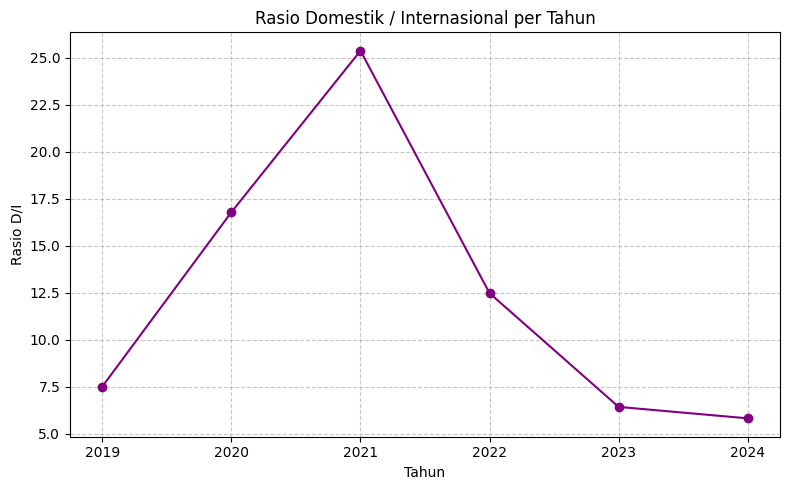

       pesawat_D  pesawat_I  rasio_D_I
tahun                                 
2019      114597      15266   7.506682
2020       65356       3892  16.792395
2021       53822       2120  25.387736
2022       72239       5789  12.478666
2023       83407      12984   6.423829
2024       80827      13899   5.815310


In [25]:
rekap_tahun = df_rekap.groupby("tahun")[["pesawat_D","pesawat_I"]].sum()
rekap_tahun["rasio_D_I"] = rekap_tahun["pesawat_D"] / rekap_tahun["pesawat_I"]

plt.figure(figsize=(8,5))
plt.plot(rekap_tahun.index, rekap_tahun["rasio_D_I"], marker="o", color="purple")
plt.title("Rasio Domestik / Internasional per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Rasio D/I")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

print(rekap_tahun)


# Analisis Rasio Domestik vs Internasional (2019–2024)

## 🔹 Rasio D/I per Tahun
- **2019** → 7,5  
- **2020** → 16,9  
- **2021** → 25,3 (puncak rasio, internasional hampir lumpuh)  
- **2022** → 12,5  
- **2023** → 6,5  
- **2024** → 5,8 (mendekati normalisasi pra-pandemi)

👉 Terlihat jelas: pandemi membuat **rasio melonjak** karena domestik lebih cepat pulih, sementara internasional terhenti. Setelah 2022, rasio kembali turun mendekati kondisi normal.

---

## 🔹 Statistik Rata-rata Harian
- **Domestik**:  
  - Rata-rata: **214,53 flight/hari**  
  - Std Deviasi: **71,05**  
  - Coefficient of Variation (CV): **33,12%** → relatif stabil  

- **Internasional**:  
  - Rata-rata: **24,61 flight/hari**  
  - Std Deviasi: **16,34**  
  - CV: **66,38%** → jauh lebih fluktuatif  

---

## 📌 Insight Utama
- **Domestik lebih stabil** (CV ~33%) → backbone operasional bandara.  
- **Internasional sangat fluktuatif** (CV ~66%) → sensitif terhadap kebijakan global & pembatasan perjalanan.  
- **2021 jadi titik ekstrem**: rasio tertinggi (25:1), mencerminkan ketergantungan penuh pada domestik.  
- **2023–2024**: rasio menurun → tanda **pemulihan internasional lebih cepat** dibanding domestik.  


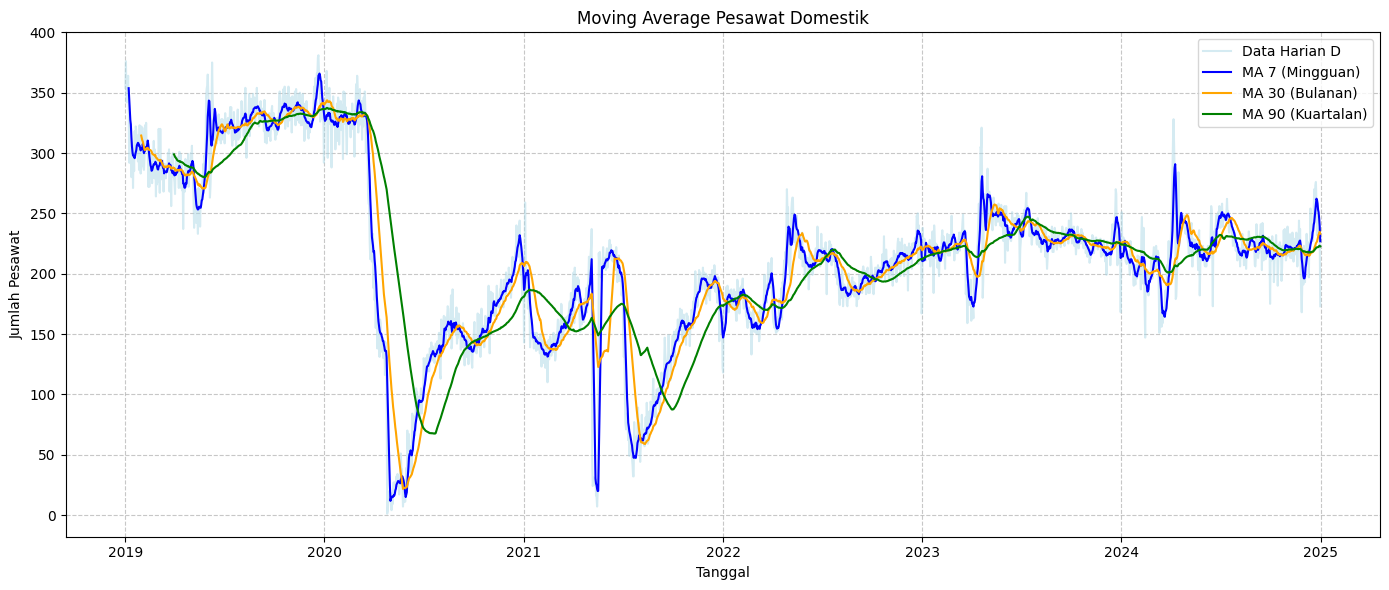

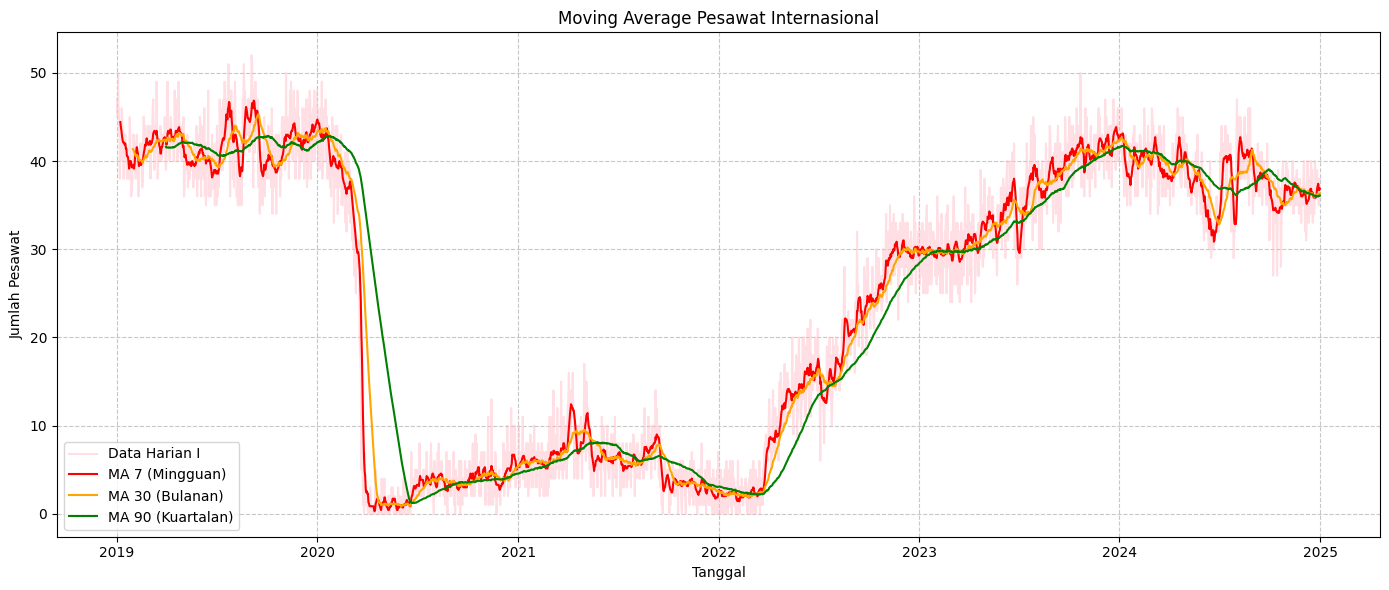

In [26]:

df_rekap["MA7_D"] = df_rekap["pesawat_D"].rolling(window=7).mean()
df_rekap["MA30_D"] = df_rekap["pesawat_D"].rolling(window=30).mean()
df_rekap["MA90_D"] = df_rekap["pesawat_D"].rolling(window=90).mean()

df_rekap["MA7_I"] = df_rekap["pesawat_I"].rolling(window=7).mean()
df_rekap["MA30_I"] = df_rekap["pesawat_I"].rolling(window=30).mean()
df_rekap["MA90_I"] = df_rekap["pesawat_I"].rolling(window=90).mean()

plt.figure(figsize=(14,6))
plt.plot(df_rekap["tanggal"], df_rekap["pesawat_D"], color="lightblue", alpha=0.5, label="Data Harian D")
plt.plot(df_rekap["tanggal"], df_rekap["MA7_D"], color="blue", label="MA 7 (Mingguan)")
plt.plot(df_rekap["tanggal"], df_rekap["MA30_D"], color="orange", label="MA 30 (Bulanan)")
plt.plot(df_rekap["tanggal"], df_rekap["MA90_D"], color="green", label="MA 90 (Kuartalan)")
plt.title("Moving Average Pesawat Domestik")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Pesawat")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,6))
plt.plot(df_rekap["tanggal"], df_rekap["pesawat_I"], color="pink", alpha=0.5, label="Data Harian I")
plt.plot(df_rekap["tanggal"], df_rekap["MA7_I"], color="red", label="MA 7 (Mingguan)")
plt.plot(df_rekap["tanggal"], df_rekap["MA30_I"], color="orange", label="MA 30 (Bulanan)")
plt.plot(df_rekap["tanggal"], df_rekap["MA90_I"], color="green", label="MA 90 (Kuartalan)")
plt.title("Moving Average Pesawat Internasional")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Pesawat")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# 🔎 Analisis Support & Golden Cross

## 🟦 Domestik
- **Support utama**:
  - ~50–70 flight/hari (awal 2020, titik terendah pandemi).
  - ~180–200 flight/hari (support baru sejak 2022).
- **Golden Cross**:
  - Pertengahan 2021 → tanda awal rebound.
  - Awal 2022 → pemulihan lebih stabil.

## 🟥 Internasional
- **Support utama**:
  - ~0–5 flight/hari (2020–2021, lumpuh total).
  - ~30 flight/hari (support baru sejak 2023).
- **Golden Cross**:
  - Tahun 2022 → sinyal re-opening borders & recovery kuat.

---

## 📌 Insight
- **Support 2020–2021** menandai titik nadir akibat pandemi.
- **Golden Cross** di 2021–2022 menjadi sinyal pemulihan nyata.
- Saat ini (2023–2024), baik domestik maupun internasional sudah berada jauh di atas support lama.


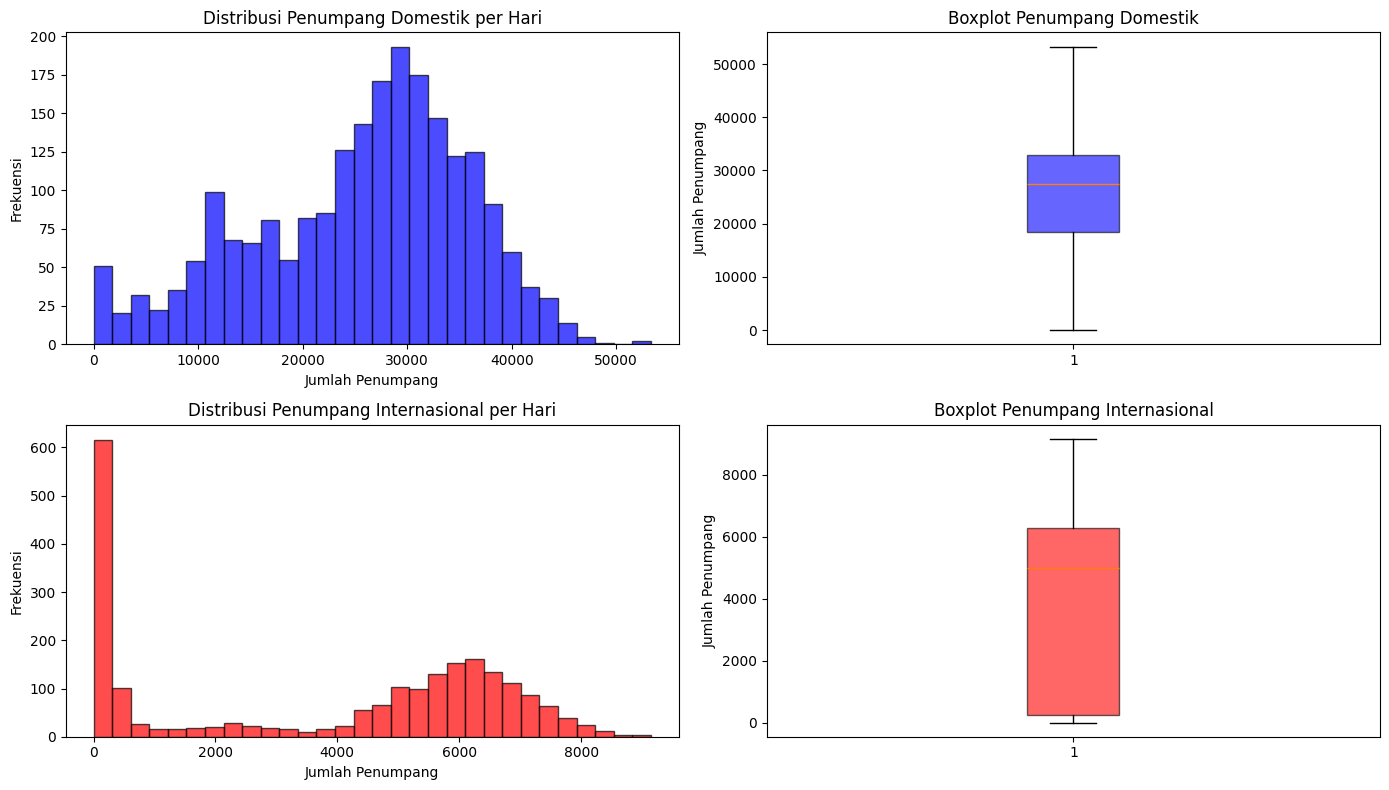

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(14,8))


axes[0,0].hist(df_rekap["total pax_D"], bins=30, color="blue", alpha=0.7, edgecolor="black")
axes[0,0].set_title("Distribusi Penumpang Domestik per Hari")
axes[0,0].set_xlabel("Jumlah Penumpang")
axes[0,0].set_ylabel("Frekuensi")

axes[0,1].boxplot(df_rekap["total pax_D"], vert=True, patch_artist=True,
                  boxprops=dict(facecolor="blue", alpha=0.6))
axes[0,1].set_title("Boxplot Penumpang Domestik")
axes[0,1].set_ylabel("Jumlah Penumpang")


axes[1,0].hist(df_rekap["total pax_I"], bins=30, color="red", alpha=0.7, edgecolor="black")
axes[1,0].set_title("Distribusi Penumpang Internasional per Hari")
axes[1,0].set_xlabel("Jumlah Penumpang")
axes[1,0].set_ylabel("Frekuensi")


axes[1,1].boxplot(df_rekap["total pax_I"], vert=True, patch_artist=True,
                  boxprops=dict(facecolor="red", alpha=0.6))
axes[1,1].set_title("Boxplot Penumpang Internasional")
axes[1,1].set_ylabel("Jumlah Penumpang")

plt.tight_layout()
plt.show()


In [28]:
from scipy.stats import shapiro

shapiro_pesawat_D = shapiro(df_rekap["pesawat_D"])
shapiro_penumpang_D = shapiro(df_rekap["total pax_D"])

shapiro_pesawat_I = shapiro(df_rekap["pesawat_I"])
shapiro_penumpang_I = shapiro(df_rekap["total pax_I"])

print("Domestik:")
print(" Pesawat D -> Statistik:", shapiro_pesawat_D.statistic, "p-value:", shapiro_pesawat_D.pvalue)
print(" Penumpang D -> Statistik:", shapiro_penumpang_D.statistic, "p-value:", shapiro_penumpang_D.pvalue)

print("\nInternasional:")
print(" Pesawat I -> Statistik:", shapiro_pesawat_I.statistic, "p-value:", shapiro_pesawat_I.pvalue)
print(" Penumpang I -> Statistik:", shapiro_penumpang_I.statistic, "p-value:", shapiro_penumpang_I.pvalue)


Domestik:
 Pesawat D -> Statistik: 0.970271646976471 p-value: 6.665593032085273e-21
 Penumpang D -> Statistik: 0.970055103302002 p-value: 5.598309514248091e-21

Internasional:
 Pesawat I -> Statistik: 0.8646679520606995 p-value: 6.2082566644060966e-40
 Penumpang I -> Statistik: 0.8414621949195862 p-value: 2.7143151253971707e-42


In [29]:
from scipy.stats import spearmanr

rho_D, pval_D = spearmanr(df_rekap["pesawat_D"], df_rekap["total pax_D"])
rho_I, pval_I = spearmanr(df_rekap["pesawat_I"], df_rekap["total pax_I"])

print("Domestik:")
print(f" Spearman ρ = {rho_D:.3f}, p-value = {pval_D:.3e}")

print("\nInternasional:")
print(f" Spearman ρ = {rho_I:.3f}, p-value = {pval_I:.3e}")


Domestik:
 Spearman ρ = 0.941, p-value = 0.000e+00

Internasional:
 Spearman ρ = 0.941, p-value = 0.000e+00


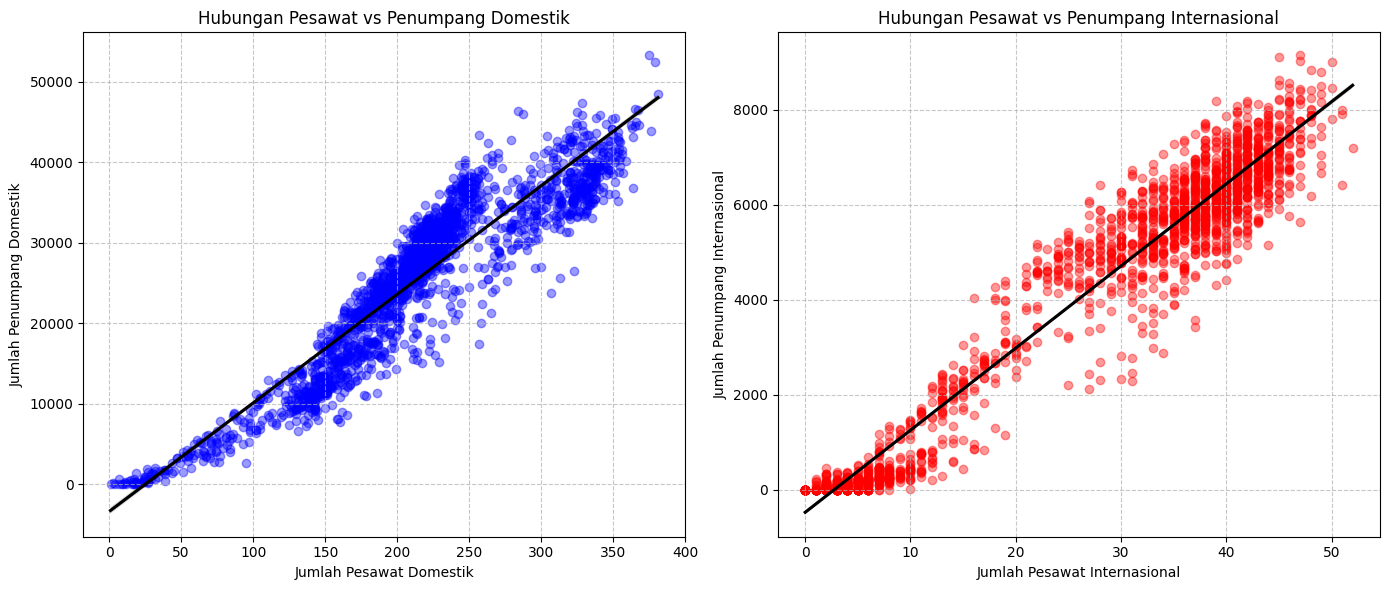

In [30]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.regplot(
    x="pesawat_D", y="total pax_D", data=df_rekap,
    scatter_kws={"alpha":0.4, "color":"blue"},
    line_kws={"color":"black"}, ax=axes[0]
)
axes[0].set_title("Hubungan Pesawat vs Penumpang Domestik")
axes[0].set_xlabel("Jumlah Pesawat Domestik")
axes[0].set_ylabel("Jumlah Penumpang Domestik")
axes[0].grid(True, linestyle="--", alpha=0.7)

sns.regplot(
    x="pesawat_I", y="total pax_I", data=df_rekap,
    scatter_kws={"alpha":0.4, "color":"red"},
    line_kws={"color":"black"}, ax=axes[1]
)
axes[1].set_title("Hubungan Pesawat vs Penumpang Internasional")
axes[1].set_xlabel("Jumlah Pesawat Internasional")
axes[1].set_ylabel("Jumlah Penumpang Internasional")
axes[1].grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


# Hubungan Pesawat vs Penumpang (2019–2024)

## 🟦 Domestik
- **Korelasi Pearson (Pesawat D)**: r = 0.970, p < 0.001 → sangat kuat & signifikan.
- **Korelasi Pearson (Penumpang D)**: r = 0.970, p < 0.001 → sangat kuat.
- **Spearman ρ**: 0.941, p < 0.001 → hubungan monotonic sangat kuat.
- **Scatter plot**: menunjukkan pola hampir linear → semakin banyak pesawat, semakin banyak penumpang.

📌 **Insight**: Jumlah penumpang domestik **sangat sebanding** dengan jumlah pesawat. Bandara Juanda berperan efektif sebagai hub domestik.

---

## 🟥 Internasional
- **Korelasi Pearson (Pesawat I)**: r = 0.865, p < 0.001 → kuat & signifikan.
- **Korelasi Pearson (Penumpang I)**: r = 0.841, p < 0.001 → kuat & signifikan.
- **Spearman ρ**: 0.941, p < 0.001 → hubungan monotonic sangat kuat.
- **Scatter plot**: linear positif, meski sebaran lebih melebar dibanding domestik.

📌 **Insight**: Hubungan penerbangan & penumpang internasional juga **kuat**, tapi **lebih fluktuatif** dibanding domestik.

---

## 📌 Insight Utama
- **Domestik** → hubungan pesawat & penumpang **sangat konsisten & stabil**.  
- **Internasional** → juga kuat, namun **lebih volatil**.  
- Korelasi tinggi ini menunjukkan **penumpang adalah fungsi langsung dari jumlah pesawat** → utilisasi kapasitas relatif stabil.  


In [31]:
df_rekap["pax_per_pesawat_D"] = df_rekap["total pax_D"] / df_rekap["pesawat_D"]
df_rekap["pax_per_pesawat_I"] = df_rekap["total pax_I"] / df_rekap["pesawat_I"]

avg_ldf_D = df_rekap["pax_per_pesawat_D"].mean()
avg_ldf_I = df_rekap["pax_per_pesawat_I"].mean()

print(f"Rata-rata Penumpang per Pesawat Domestik: {avg_ldf_D:.0f}")
print(f"Rata-rata Penumpang per Pesawat Internasional: {avg_ldf_I:.0f}")


Rata-rata Penumpang per Pesawat Domestik: 114
Rata-rata Penumpang per Pesawat Internasional: 120


In [32]:
df_rekap["tahun"] = pd.to_datetime(df_rekap["tanggal"]).dt.year

rekap_tahun = (
    df_rekap.groupby("tahun")
    .agg(
        pax_D=("total pax_D", "sum"),
        pax_I=("total pax_I", "sum"),
        pesawat_D=("pesawat_D", "sum"),
        pesawat_I=("pesawat_I", "sum"),
    )
    .reset_index()
)

rekap_tahun["avg_pax_per_pesawat_D"] = rekap_tahun["pax_D"] / rekap_tahun["pesawat_D"]
rekap_tahun["avg_pax_per_pesawat_I"] = rekap_tahun["pax_I"] / rekap_tahun["pesawat_I"]

hasil = rekap_tahun[["tahun", "avg_pax_per_pesawat_D", "avg_pax_per_pesawat_I"]].round(2)
print(hasil)


   tahun  avg_pax_per_pesawat_D  avg_pax_per_pesawat_I
0   2019                 116.93                 157.70
1   2020                  90.73                 110.57
2   2021                  99.73                  36.94
3   2022                 127.23                 163.45
4   2023                 133.06                 162.17
5   2024                 136.84                 166.91


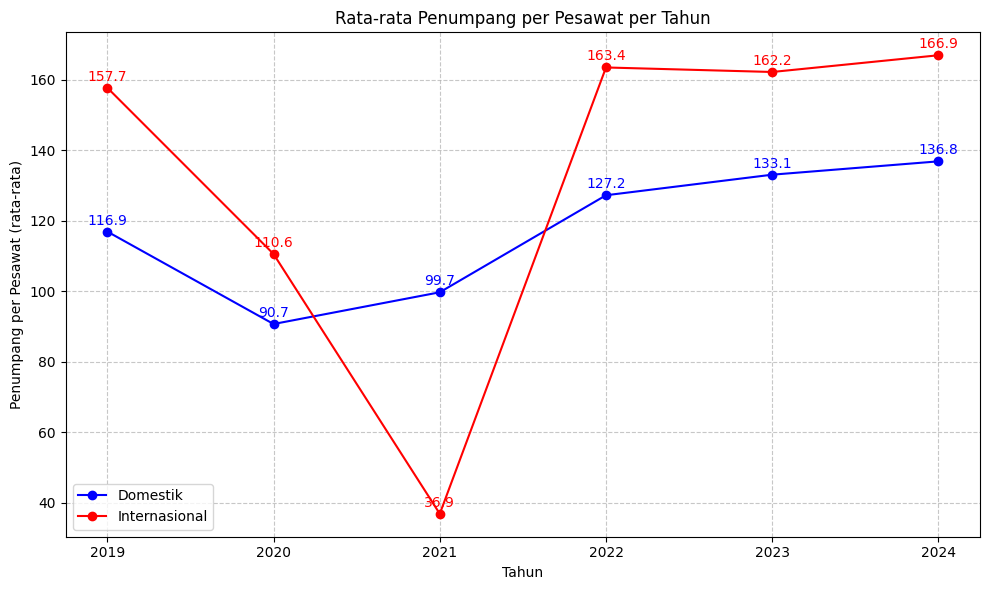

In [33]:
plt.figure(figsize=(10,6))
plt.plot(hasil["tahun"], hasil["avg_pax_per_pesawat_D"], 
         marker="o", color="blue", label="Domestik")

plt.plot(hasil["tahun"], hasil["avg_pax_per_pesawat_I"], 
         marker="o", color="red", label="Internasional")

for i, val in enumerate(hasil["avg_pax_per_pesawat_D"]):
    plt.text(hasil["tahun"][i], val+2, f"{val:.1f}", ha="center", color="blue")

for i, val in enumerate(hasil["avg_pax_per_pesawat_I"]):
    plt.text(hasil["tahun"][i], val+2, f"{val:.1f}", ha="center", color="red")

plt.title("Rata-rata Penumpang per Pesawat per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Penumpang per Pesawat (rata-rata)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# 👥 Rata-rata Penumpang per Pesawat (2019–2024)

## 🟦 Domestik
- **2019** → 116,9 penumpang/pesawat.
- **2020** → turun jadi 90,7 (dampak pandemi).
- **2021** → naik tipis ke 99,7.
- **2022** → lonjakan signifikan ke 127,2.
- **2023** → naik lagi ke 133,1.
- **2024** → stabil di 136,8.

📌 Insight: tren domestik **stabil naik** sejak 2021 → utilisasi kapasitas membaik, walau masih lebih rendah dari kapasitas maksimum tipikal pesawat narrow-body (150–180 pax).

---

## 🟥 Internasional
- **2019** → 157,7 penumpang/pesawat.
- **2020** → anjlok ke 110,6.
- **2021** → titik terendah hanya 36,9 (karena banyak penerbangan minim penumpang).
- **2022** → rebound besar ke 163,4.
- **2023** → sedikit turun ke 162,2.
- **2024** → tertinggi di 166,9.

📌 Insight: internasional lebih **volatil**, tapi setelah 2022 sudah kembali ke level bahkan **lebih tinggi dibanding 2019** → load factor penerbangan internasional sangat kuat.

---

## 📌 Insight Utama
- **Domestik** → recovery lebih konsisten, tren naik perlahan sejak 2021.  
- **Internasional** → sangat tertekan di 2020–2021, namun rebound besar di 2022–2024.  
- Tahun **2024**:  
  - Domestik rata-rata ~137 pax/pesawat.  
  - Internasional rata-rata ~167 pax/pesawat (lebih optimal utilisasinya).  


In [34]:

df_rekap["tanggal"] = pd.to_datetime(df_rekap["tanggal"])

df_kargo_mingguan = df_rekap.resample("W", on="tanggal")["kargo (kg)_I"].sum().reset_index()

# Plot
fig = px.line(
    df_kargo_mingguan,
    x="tanggal",
    y="kargo (kg)_I",
    title="Kargo Internasional per Minggu",
    labels={"tanggal": "Tanggal", "kargo (kg)_I": "Jumlah Kargo (kg)"}
)

fig.update_traces(line=dict(color="red"))
fig.update_layout(
    template="plotly_white",
    hovermode="x unified"
)

fig.show()


C:\Users\puguh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\kaleido\__init__.py:14: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




In [35]:
rekap_bagasi_kargo = (
    df_rekap.groupby("tahun")
    .agg(
        bagasi_D=("bagasi (kg)_D", "sum"),
        bagasi_I=("bagasi (kg)_I", "sum"),
        kargo_D=("kargo (kg)_D", "sum"),
        kargo_I=("kargo (kg)_I", "sum")
    )
    .reset_index()
)

print(rekap_bagasi_kargo)


   tahun  bagasi_D  bagasi_I   kargo_D   kargo_I
0   2019  67255286  33577632  61751553  26552956
1   2020  28847929   6622008  52730129  12580754
2   2021  33494751   1663410  55608258  14636149
3   2022  71241953  14350224  57867176  10546177
4   2023  84138819  28540663  54685093  12837795
5   2024  83369137  32618425  63806140  17609241


In [36]:
rekap_bagasi_kargo["bagasi_per_pax_D"] = rekap_bagasi_kargo["bagasi_D"] / rekap_tahun["pax_D"]
rekap_bagasi_kargo["bagasi_per_pax_I"] = rekap_bagasi_kargo["bagasi_I"] / rekap_tahun["pax_I"]

rekap_bagasi_kargo["kargo_per_pesawat_D"] = rekap_bagasi_kargo["kargo_D"] / rekap_tahun["pesawat_D"]
rekap_bagasi_kargo["kargo_per_pesawat_I"] = rekap_bagasi_kargo["kargo_I"] / rekap_tahun["pesawat_I"]

print(rekap_bagasi_kargo[["tahun","bagasi_per_pax_D","bagasi_per_pax_I","kargo_per_pesawat_D","kargo_per_pesawat_I"]].round(2))


   tahun  bagasi_per_pax_D  bagasi_per_pax_I  kargo_per_pesawat_D  \
0   2019              5.02             13.95               538.86   
1   2020              4.87             15.39               806.81   
2   2021              6.24             21.24              1033.19   
3   2022              7.75             15.17               801.05   
4   2023              7.58             13.55               655.64   
5   2024              7.54             14.06               789.42   

   kargo_per_pesawat_I  
0              1739.35  
1              3232.47  
2              6903.84  
3              1821.76  
4               988.74  
5              1266.94  


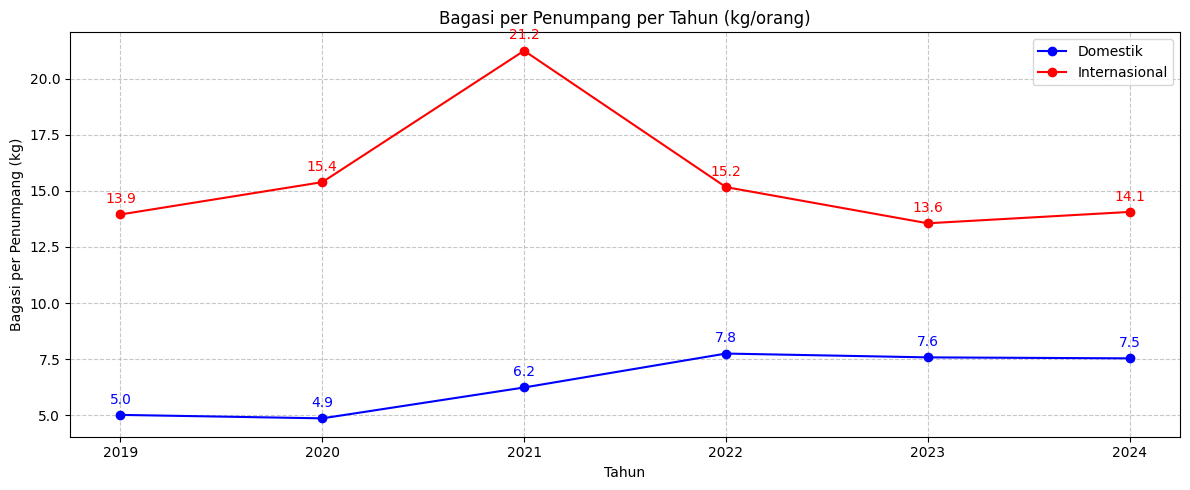

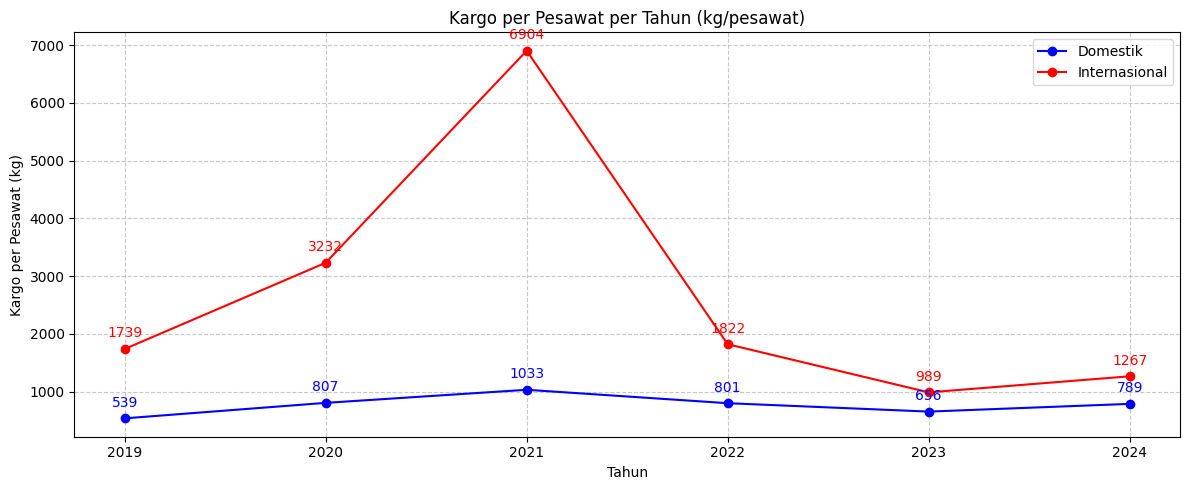

In [37]:

plt.figure(figsize=(12,5))
plt.plot(rekap_bagasi_kargo["tahun"], rekap_bagasi_kargo["bagasi_per_pax_D"], 
         marker="o", color="blue", label="Domestik")
plt.plot(rekap_bagasi_kargo["tahun"], rekap_bagasi_kargo["bagasi_per_pax_I"], 
         marker="o", color="red", label="Internasional")

for i, val in enumerate(rekap_bagasi_kargo["bagasi_per_pax_D"]):
    plt.text(rekap_bagasi_kargo["tahun"][i], val+0.5, f"{val:.1f}", ha="center", color="blue")
for i, val in enumerate(rekap_bagasi_kargo["bagasi_per_pax_I"]):
    plt.text(rekap_bagasi_kargo["tahun"][i], val+0.5, f"{val:.1f}", ha="center", color="red")

plt.title("Bagasi per Penumpang per Tahun (kg/orang)")
plt.xlabel("Tahun")
plt.ylabel("Bagasi per Penumpang (kg)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12,5))
plt.plot(rekap_bagasi_kargo["tahun"], rekap_bagasi_kargo["kargo_per_pesawat_D"], 
         marker="o", color="blue", label="Domestik")
plt.plot(rekap_bagasi_kargo["tahun"], rekap_bagasi_kargo["kargo_per_pesawat_I"], 
         marker="o", color="red", label="Internasional")

for i, val in enumerate(rekap_bagasi_kargo["kargo_per_pesawat_D"]):
    plt.text(rekap_bagasi_kargo["tahun"][i], val+200, f"{val:.0f}", ha="center", color="blue")
for i, val in enumerate(rekap_bagasi_kargo["kargo_per_pesawat_I"]):
    plt.text(rekap_bagasi_kargo["tahun"][i], val+200, f"{val:.0f}", ha="center", color="red")

plt.title("Kargo per Pesawat per Tahun (kg/pesawat)")
plt.xlabel("Tahun")
plt.ylabel("Kargo per Pesawat (kg)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [38]:
rho_bagasi_D, pval_bagasi_D = spearmanr(df_rekap["total pax_D"], df_rekap["bagasi (kg)_D"])

# --- Internasional ---
rho_bagasi_I, pval_bagasi_I = spearmanr(df_rekap["total pax_I"], df_rekap["bagasi (kg)_I"])

print("Domestik:")
print(f" Spearman ρ = {rho_bagasi_D:.3f}, p-value = {pval_bagasi_D:.3e}")

print("\nInternasional:")
print(f" Spearman ρ = {rho_bagasi_I:.3f}, p-value = {pval_bagasi_I:.3e}")

Domestik:
 Spearman ρ = 0.766, p-value = 0.000e+00

Internasional:
 Spearman ρ = 0.966, p-value = 0.000e+00


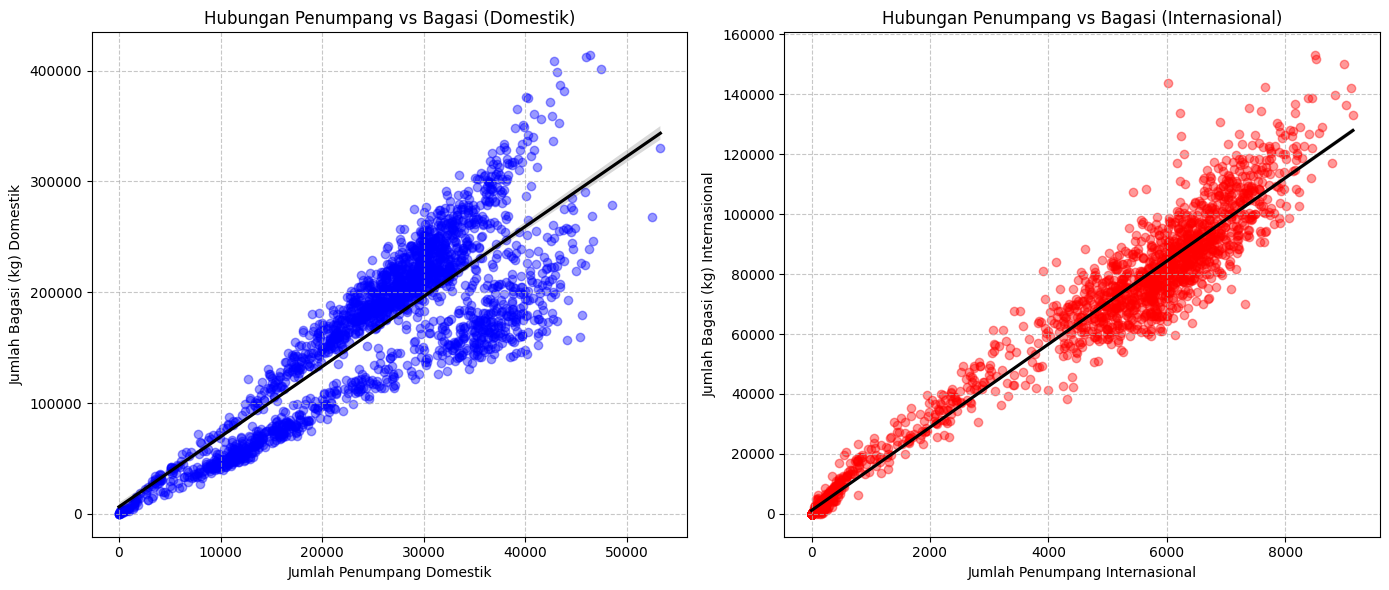

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# --- Domestik ---
sns.regplot(
    x="total pax_D", y="bagasi (kg)_D", data=df_rekap,
    scatter_kws={"alpha":0.4, "color":"blue"},
    line_kws={"color":"black"}, ax=axes[0]
)
axes[0].set_title("Hubungan Penumpang vs Bagasi (Domestik)")
axes[0].set_xlabel("Jumlah Penumpang Domestik")
axes[0].set_ylabel("Jumlah Bagasi (kg) Domestik")
axes[0].grid(True, linestyle="--", alpha=0.7)

# --- Internasional ---
sns.regplot(
    x="total pax_I", y="bagasi (kg)_I", data=df_rekap,
    scatter_kws={"alpha":0.4, "color":"red"},
    line_kws={"color":"black"}, ax=axes[1]
)
axes[1].set_title("Hubungan Penumpang vs Bagasi (Internasional)")
axes[1].set_xlabel("Jumlah Penumpang Internasional")
axes[1].set_ylabel("Jumlah Bagasi (kg) Internasional")
axes[1].grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

#  Analisis Kargo & Bagasi (2019–2024)

## 🟦 Kargo per Pesawat
- **Domestik**:
  - Relatif stabil di kisaran **500–1.000 kg/pesawat**.
  - Puncak pada 2021 (1.033 kg), lalu normal kembali ~800–900 kg.
- **Internasional**:
  - Sangat volatil.
  - 2019 → 1.739 kg/pesawat.
  - 2021 → melonjak ke **6.984 kg/pesawat** (peak pandemi, kargo jadi prioritas).
  - 2022–2024 → turun lagi ke ~1.200 kg/pesawat.

📌 Insight: **Kargo internasional melonjak saat pandemi** karena penurunan pax membuat maskapai fokus pada pengangkutan barang.

---

## 🧳 Bagasi per Penumpang
- **Domestik**:
  - Stabil di **5–8 kg/orang**.
  - Puncak 2022 (7,8 kg), lalu stabil 7,5 kg.
- **Internasional**:
  - Lebih besar dan fluktuatif.
  - 2019 → 13,9 kg/orang.
  - 2021 → melonjak ke **21,2 kg/orang**.
  - 2022–2024 → stabil di kisaran 13–15 kg/orang.

📌 Insight: Penumpang internasional cenderung membawa bagasi **2x lebih banyak** dibanding domestik.

---

## 🔗 Hubungan Penumpang vs Bagasi
- **Domestik**:
  - Scatter plot menunjukkan hubungan **linear kuat**.
  - Semakin banyak penumpang → semakin besar total bagasi.
- **Internasional**:
  - Hubungan juga linear, meski lebih menyebar (variasi lebih tinggi).
  - Korelasi tetap kuat → jumlah penumpang adalah prediktor utama total bagasi.

📌 Insight:  
- **Domestik → pola konsisten**, utilisasi bagasi lebih terprediksi.  
- **Internasional → lebih variatif**, mungkin dipengaruhi profil perjalanan (turis vs pekerja migran).  


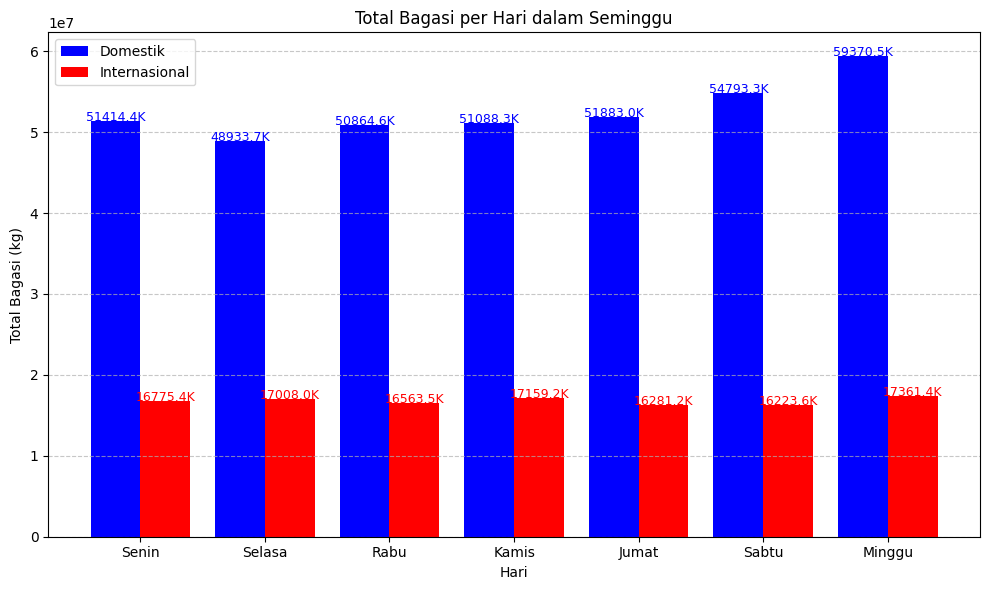

In [40]:

rekap_bagasi_hari = (
    df_rekap.groupby("hari")[["bagasi (kg)_D","bagasi (kg)_I"]]
    .sum()
    .reindex(["Senin","Selasa","Rabu","Kamis","Jumat","Sabtu","Minggu"])
)

plt.figure(figsize=(10,6))
x = range(len(rekap_bagasi_hari))

plt.bar([i-0.2 for i in x], rekap_bagasi_hari["bagasi (kg)_D"], width=0.4, color="blue", label="Domestik")
plt.bar([i+0.2 for i in x], rekap_bagasi_hari["bagasi (kg)_I"], width=0.4, color="red", label="Internasional")

for i, val in enumerate(rekap_bagasi_hari["bagasi (kg)_D"]):
    plt.text(i-0.2, val+1000, f"{val/1000:.1f}K", ha="center", color="blue", fontsize=9)
for i, val in enumerate(rekap_bagasi_hari["bagasi (kg)_I"]):
    plt.text(i+0.2, val+1000, f"{val/1000:.1f}K", ha="center", color="red", fontsize=9)

plt.xticks(x, rekap_bagasi_hari.index)
plt.title("Total Bagasi per Hari dalam Seminggu")
plt.xlabel("Hari")
plt.ylabel("Total Bagasi (kg)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# 🧳 Total Bagasi per Hari dalam Seminggu

## 🟦 Domestik
- **Tertinggi**: Minggu (**59,370K kg**) → puncak arus penumpang akhir pekan.
- **Terendah**: Selasa (**48,933K kg**) → aktivitas lebih rendah di awal minggu.
- Pola umum: naik signifikan dari Jumat → Sabtu → Minggu.

## 🟥 Internasional
- **Tertinggi**: Minggu (**17,361K kg**) → selaras dengan domestik, akhir pekan lebih ramai.
- **Terendah**: Sabtu (**16,223K kg**) → sedikit menurun sebelum naik lagi di Minggu.
- Pola lebih **flat** dibanding domestik, dengan fluktuasi kecil antar-hari.

---

## 📌 Insight Utama
- **Weekend effect jelas terlihat**, terutama pada penerbangan domestik → lonjakan bagasi di Sabtu–Minggu.
- **Domestik jauh lebih dominan** (3x lipat internasional), konsisten dengan volume penumpang yang lebih besar.
- **Selasa sebagai titik terendah** → kemungkinan hari dengan aktivitas perjalanan paling sedikit.
- **Sinkronisasi pola**: baik domestik maupun internasional mencapai puncak di **Minggu**, menegaskan karakteristik bandara Juanda sebagai hub mobilitas akhir pekan.


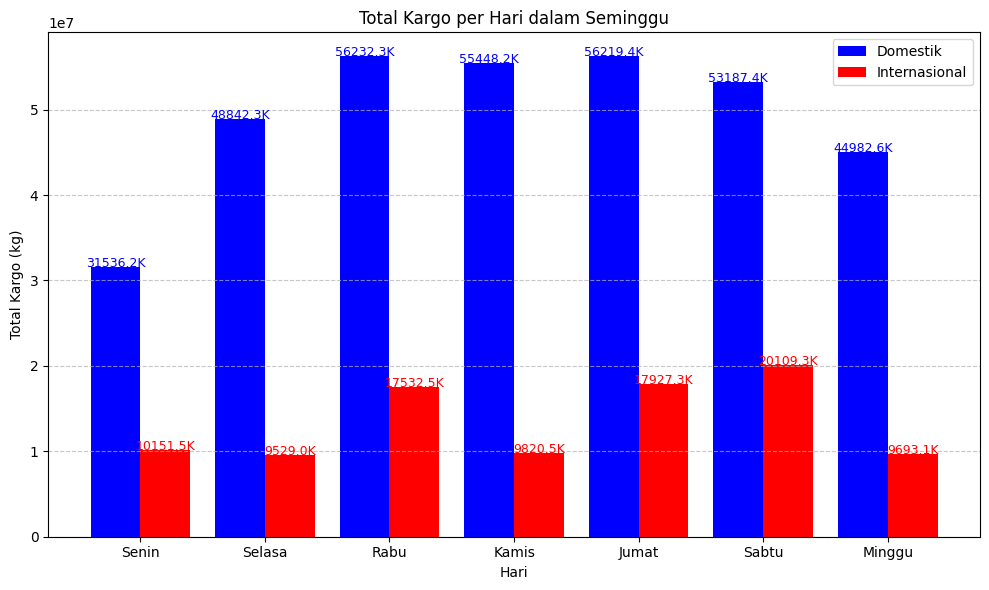

In [41]:

rekap_kargo_hari = (
    df_rekap.groupby("hari")[['kargo (kg)_D',"kargo (kg)_I"]]
    .sum()
    .reindex(["Senin","Selasa","Rabu","Kamis","Jumat","Sabtu","Minggu"])
)

plt.figure(figsize=(10,6))
x = range(len(rekap_kargo_hari))

plt.bar([i-0.2 for i in x], rekap_kargo_hari["kargo (kg)_D"], width=0.4, color="blue", label="Domestik")
plt.bar([i+0.2 for i in x], rekap_kargo_hari["kargo (kg)_I"], width=0.4, color="red", label="Internasional")

for i, val in enumerate(rekap_kargo_hari["kargo (kg)_D"]):
    plt.text(i-0.2, val+1000, f"{val/1000:.1f}K", ha="center", color="blue", fontsize=9)
for i, val in enumerate(rekap_kargo_hari["kargo (kg)_I"]):
    plt.text(i+0.2, val+1000, f"{val/1000:.1f}K", ha="center", color="red", fontsize=9)

plt.xticks(x, rekap_kargo_hari.index)
plt.title("Total Kargo per Hari dalam Seminggu")
plt.xlabel("Hari")
plt.ylabel("Total Kargo (kg)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# 📦 Total Kargo per Hari dalam Seminggu

## 🟦 Domestik
- **Tertinggi**: Rabu (**56,232K kg**) & Kamis (**55,448K kg**) → arus distribusi logistik kuat di pertengahan minggu.
- **Terendah**: Senin (**31,536K kg**) → awal minggu cenderung rendah.
- Pola: naik dari Senin → puncak pertengahan minggu → menurun di akhir pekan.

## 🟥 Internasional
- **Tertinggi**: Sabtu (**20,109K kg**) → distribusi kargo internasional memuncak di akhir pekan.
- **Terendah**: Kamis (**9,820K kg**) → relatif rendah sebelum lonjakan akhir minggu.
- Pola: lebih fluktuatif, dengan variasi antar-hari lebih besar dibanding domestik.

---

## 📌 Insight Utama
- **Domestik dominan** (±5x lebih besar dari internasional), menegaskan peran Juanda sebagai hub distribusi nasional.
- **Domestik → padat di pertengahan minggu (Rabu–Kamis)**. Hal ini selaras dengan siklus logistik umum:  
  - **Senin** → awal minggu, pengiriman masih disiapkan (barang keluar dari gudang/pabrik).  
  - **Selasa–Kamis** → periode paling aktif agar barang sampai sebelum akhir pekan.  
  - **Jumat–Minggu** → aktivitas melambat karena penerima (toko, kantor, gudang) banyak yang libur/mengurangi jam operasional.  
- **Internasional → puncak di akhir pekan (Sabtu)**, kemungkinan terkait sinkronisasi jadwal penerbangan kargo antarhub global.


In [42]:
rekap_kargo_pax = (
    df_rekap.groupby("tahun")
    .agg(
        kargo_D=("kargo (kg)_D", "sum"),
        kargo_I=("kargo (kg)_I", "sum"),
        pax_D=("total pax_D", "sum"),
        pax_I=("total pax_I", "sum")
    )
    .reset_index()
)

rekap_kargo_pax["kargo_per_pax_D"] = rekap_kargo_pax["kargo_D"] / rekap_kargo_pax["pax_D"]
rekap_kargo_pax["kargo_per_pax_I"] = rekap_kargo_pax["kargo_I"] / rekap_kargo_pax["pax_I"]

print(rekap_kargo_pax[["tahun","kargo_per_pax_D","kargo_per_pax_I"]].round(2))


   tahun  kargo_per_pax_D  kargo_per_pax_I
0   2019             4.61            11.03
1   2020             8.89            29.23
2   2021            10.36           186.90
3   2022             6.30            11.15
4   2023             4.93             6.10
5   2024             5.77             7.59


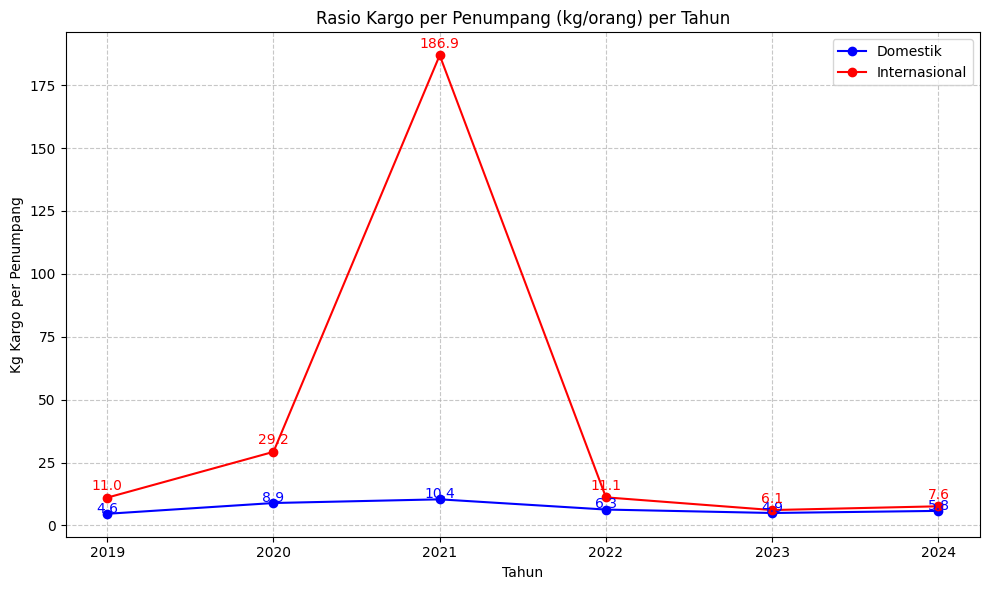

In [43]:
plt.figure(figsize=(10,6))

# Plot Domestik
plt.plot(rekap_kargo_pax["tahun"], rekap_kargo_pax["kargo_per_pax_D"],
         marker="o", color="blue", label="Domestik")

# Plot Internasional
plt.plot(rekap_kargo_pax["tahun"], rekap_kargo_pax["kargo_per_pax_I"],
         marker="o", color="red", label="Internasional")

# Tambahkan angka di atas titik
for i, val in enumerate(rekap_kargo_pax["kargo_per_pax_D"]):
    plt.text(rekap_kargo_pax["tahun"][i], val+0.5, f"{val:.1f}", ha="center", color="blue")

for i, val in enumerate(rekap_kargo_pax["kargo_per_pax_I"]):
    plt.text(rekap_kargo_pax["tahun"][i], val+3, f"{val:.1f}", ha="center", color="red")

plt.title("Rasio Kargo per Penumpang (kg/orang) per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Kg Kargo per Penumpang")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 📦 Rasio Kargo per Penumpang (kg/orang) per Tahun (2019–2024)

## 🔹 Domestik
- Relatif stabil di kisaran **4–10 kg/pax**.
- **Tertinggi 2021 (10,36 kg/pax)** → indikasi turunnya penumpang saat pandemi, sementara kargo tetap berjalan.
- **Setelah 2021 menurun** kembali ke level ~5–6 kg/pax, mendekati normal.

## 🔴 Internasional
- Fluktuasi sangat tajam:
  - **2019: 11,0 kg/pax** (baseline normal pra-pandemi).
  - **2020: naik ke 29,2 kg/pax** karena penumpang turun drastis, kargo tetap jalan.
  - **2021: melonjak ekstrem 186,9 kg/pax** → puncak pandemi, penerbangan internasional nyaris hanya kargo (*cargo-only flights*).
  - **2022: kembali turun 11,1 kg/pax** → normalisasi dengan pembukaan perjalanan.
  - **2023–2024: stabil di 6–8 kg/pax**, mendekati pola baru pasca-pandemi.

---

## 📌 Insight Utama
1. **Pandemi COVID-19 sangat memengaruhi rasio kargo per pax**, terutama di internasional (2020–2021).
2. **Internasional lebih volatile**: perubahan kebijakan border langsung berdampak ekstrem.  
3. **Domestik lebih stabil**: meski terdampak, distribusi logistik dalam negeri tetap berjalan sehingga rasio tidak melonjak setinggi internasional.  
4. Setelah 2022, baik domestik maupun internasional **menuju pola normal baru** dengan rasio lebih seimbang (sekitar 5–8 kg/pax).  


In [44]:
df_libur = pd.read_csv('libur.csv')

In [45]:
df_libur['tanggal'] = pd.to_datetime(df_libur['tanggal'])

In [46]:
df_rekap = df_rekap.merge(
    df_libur,
    on="tanggal",
    how="left"
)

In [47]:
df_rekap = df_rekap.drop(columns=["kategori"])

In [48]:
df_rekap.head()

tanggal  pesawat_D  pesawat_I  total pax_D  total pax_I  transit_D  \
0 2019-01-01        354         47        40269         8205       2057   
1 2019-01-02        376         45        43837         7684       2587   
2 2019-01-03        342         50        40886         9002       2695   
3 2019-01-04        352         43        40812         6915       2908   
4 2019-01-05        351         46        40041         6723       2810   

   transit_I  bagasi (kg)_D  bagasi (kg)_I  kargo (kg)_D  ...  nama_bulan  \
0          0         341907         120540        159981  ...     Januari   
1          0         382068         115786        117203  ...     Januari   
2          0         360797         150109        229180  ...     Januari   
3          0         340421          93097        293485  ...     Januari   
4          0         376136          90955        288927  ...     Januari   

  MA7_D  MA30_D MA90_D  MA7_I  MA30_I  MA90_I  pax_per_pesawat_D  \
0   NaN     NaN    NaN    NaN     NaN     NaN         113.754237   
1   NaN     NaN    NaN    NaN     NaN     NaN         116.587766   
2   NaN     NaN    NaN    NaN     NaN     NaN         119.549708   
3   NaN     NaN    NaN    NaN     NaN     NaN         115.943182   
4   NaN     NaN    NaN    NaN     NaN     NaN         114.076923   

   pax_per_pesawat_I                   event  
0         174.574468  Tahun Baru 2019 Masehi  
1         170.755556                     NaN  
2         180.040000                     NaN  
3         160.813953                     NaN  
4         146.152174                     NaN  

[5 rows x 23 columns]

In [49]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    subplot_titles=("Pesawat Domestik", "Pesawat Internasional")
)

fig.add_trace(go.Scatter(
    x=df_rekap["tanggal"], y=df_rekap["pesawat_D"],
    mode="lines", name="Domestik", line=dict(color="blue")
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df_rekap["tanggal"], y=df_rekap["pesawat_I"],
    mode="lines", name="Internasional", line=dict(color="red")
), row=2, col=1)

# --- Marker Event ---
df_event = df_rekap.dropna(subset=["event"]).copy()
events = df_event["event"].unique().tolist()
palette = px.colors.qualitative.Set2
color_map = {ev: palette[i % len(palette)] for i, ev in enumerate(events)}

for ev in events:
    sub = df_event[df_event["event"] == ev]
    color = color_map[ev]

    fig.add_trace(go.Scatter(
        x=sub["tanggal"], y=sub["pesawat_D"],
        mode="markers", name=ev,
        marker=dict(color=color, size=8, symbol="circle"),
        legendgroup=ev, showlegend=True,
        text=[ev]*len(sub),
        hovertemplate="%{text}<br>%{x|%d-%m-%Y}<br>Pesawat D: %{y}<extra></extra>"
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=sub["tanggal"], y=sub["pesawat_I"],
        mode="markers", name=ev,
        marker=dict(color=color, size=8, symbol="diamond"),
        legendgroup=ev, showlegend=False,
        text=[ev]*len(sub),
        hovertemplate="%{text}<br>%{x|%d-%m-%Y}<br>Pesawat I: %{y}<extra></extra>"
    ), row=2, col=1)

fig.update_layout(
    title="Jumlah Pesawat Domestik & Internasional + Event Libur/Cuti",
    hovermode="x unified",
    legend_title_text="Legenda",
    height=800,
        legend=dict(
        itemclick="toggleothers",    
        itemdoubleclick="toggle" 
))
fig.update_traces(selector=dict(name="Domestik"), visible=True)
fig.update_traces(selector=dict(name="Internasional"), visible=True)
fig.update_yaxes(title_text="Jumlah Pesawat Domestik", row=1, col=1)
fig.update_yaxes(title_text="Jumlah Pesawat Internasional", row=2, col=1)
fig.update_xaxes(title_text="Tanggal", row=2, col=1)

fig.show()


In [50]:
df_ihk = pd.read_csv('ihk.csv')
df_ihk['bulan'] = pd.to_datetime(df_ihk['bulan'])


In [51]:
df_ihk.head()

bulan     IHK
0 2019-01-01  101.51
1 2019-02-01  101.43
2 2019-03-01  101.54
3 2019-04-01  101.99
4 2019-05-01  102.68

In [52]:
# Pastikan kolom tanggal sudah datetime
df_rekap["tanggal"] = pd.to_datetime(df_rekap["tanggal"])

# Hitung rata-rata harian per bulan
df_pax_bulan = (
    df_rekap.resample("M", on="tanggal")[["total pax_D", "total pax_I"]]
    .mean()
    .reset_index()
)

# Tambahkan kolom periode (YYYY-MM)
df_pax_bulan["periode"] = df_pax_bulan["tanggal"].dt.strftime("%Y-%m")

print(df_pax_bulan.head())


     tanggal   total pax_D  total pax_I  periode
0 2019-01-31  37732.645161  6387.677419  2019-01
1 2019-02-28  35865.785714  6153.607143  2019-02
2 2019-03-31  33213.225806  6608.677419  2019-03
3 2019-04-30  32129.833333  6484.766667  2019-04
4 2019-05-31  29566.193548  5872.967742  2019-05


C:\Users\puguh\AppData\Local\Temp\ipykernel_18328\1679403991.py:6: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [53]:
df_ihk["periode"] = df_ihk["bulan"].dt.strftime("%Y-%m")
df_merged = df_pax_bulan.merge(df_ihk[["periode", "IHK"]], on="periode", how="left")    
print(df_merged.head())

     tanggal   total pax_D  total pax_I  periode     IHK
0 2019-01-31  37732.645161  6387.677419  2019-01  101.51
1 2019-02-28  35865.785714  6153.607143  2019-02  101.43
2 2019-03-31  33213.225806  6608.677419  2019-03  101.54
3 2019-04-30  32129.833333  6484.766667  2019-04  101.99
4 2019-05-31  29566.193548  5872.967742  2019-05  102.68


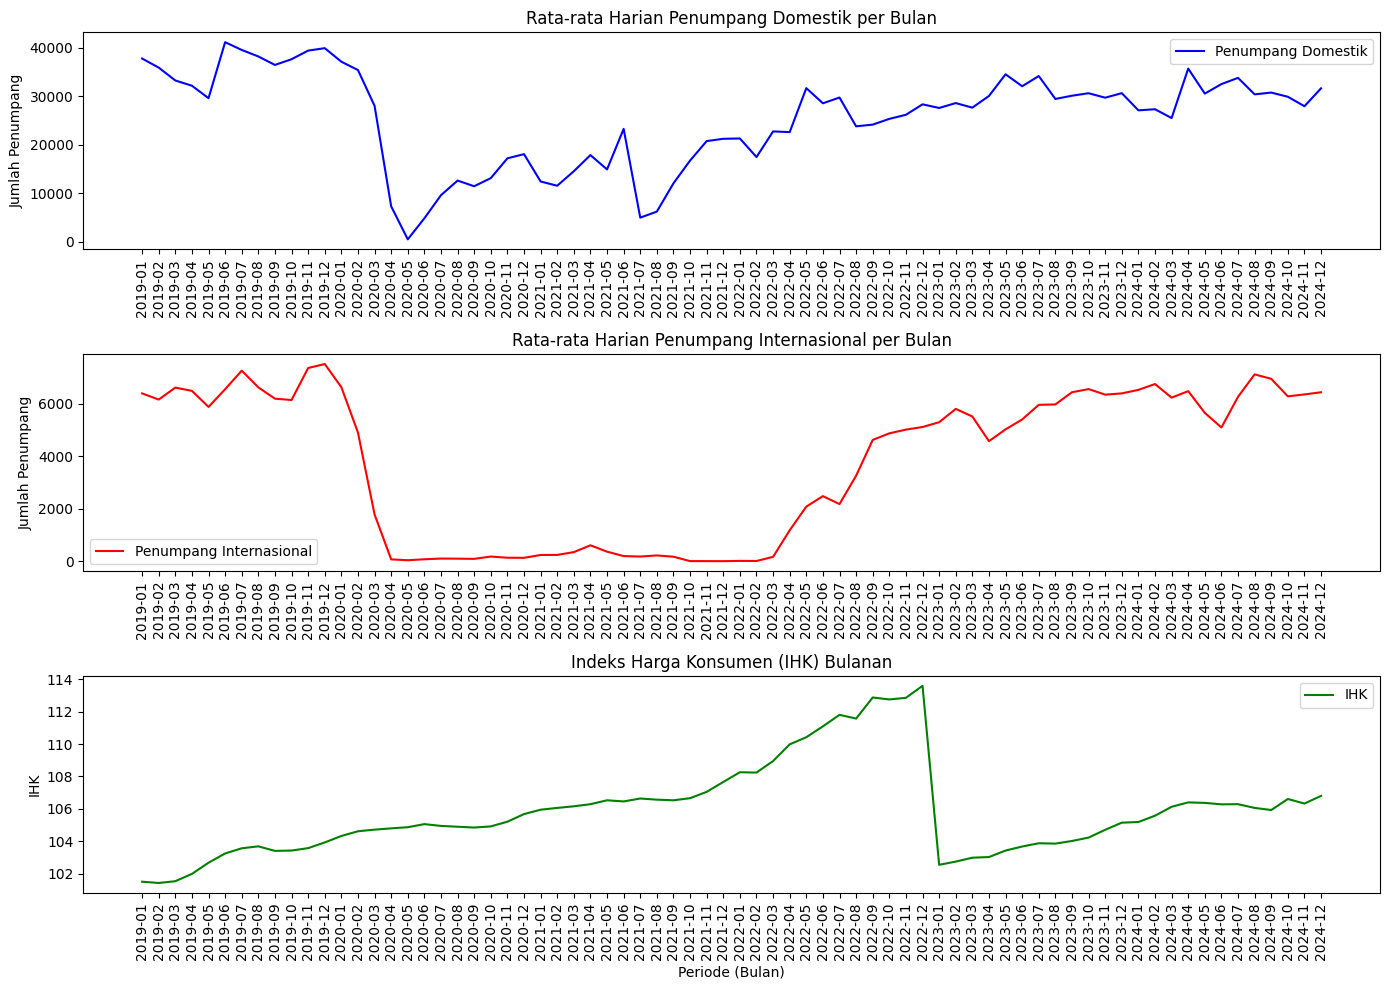

In [54]:
plt.figure(figsize=(14,10))

# --- Grafik 1: Penumpang Domestik ---
plt.subplot(3,1,1)
plt.plot(df_merged["periode"], df_merged["total pax_D"], label="Penumpang Domestik", color="blue")
plt.title("Rata-rata Harian Penumpang Domestik per Bulan")
plt.ylabel("Jumlah Penumpang")
plt.xticks(rotation=90)
plt.legend()

# --- Grafik 2: Penumpang Internasional ---
plt.subplot(3,1,2)
plt.plot(df_merged["periode"], df_merged["total pax_I"], label="Penumpang Internasional", color="red")
plt.title("Rata-rata Harian Penumpang Internasional per Bulan")
plt.ylabel("Jumlah Penumpang")
plt.xticks(rotation=90)
plt.legend()

# --- Grafik 3: IHK ---
plt.subplot(3,1,3)
plt.plot(df_merged["periode"], df_merged["IHK"], label="IHK", color="green")
plt.title("Indeks Harga Konsumen (IHK) Bulanan")
plt.ylabel("IHK")
plt.xlabel("Periode (Bulan)")
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


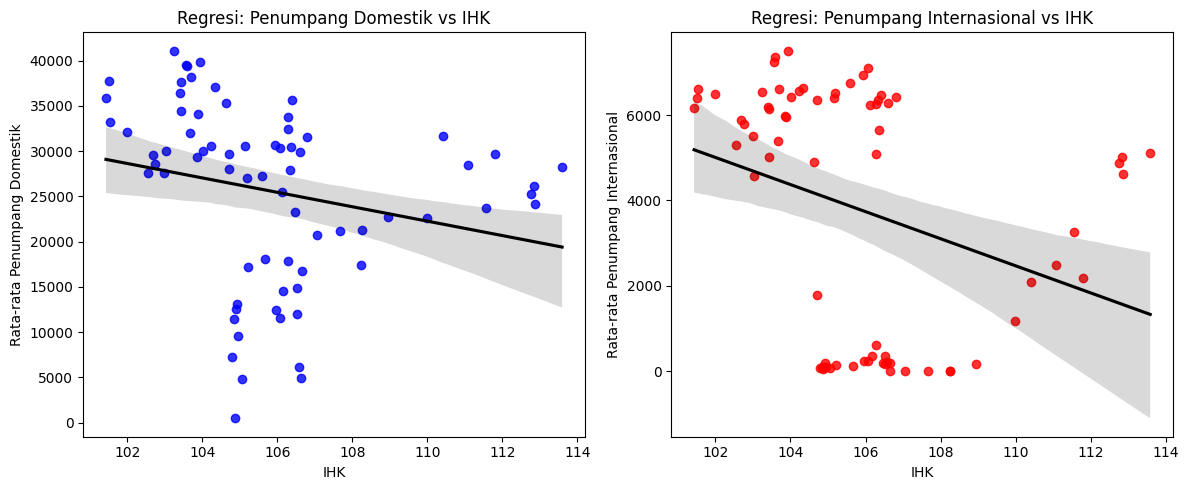

In [55]:
plt.figure(figsize=(12,5))

# --- Regresi Domestik ---
plt.subplot(1,2,1)
sns.regplot(
    data=df_merged, x="IHK", y="total pax_D",
    scatter_kws={"color":"blue"}, line_kws={"color":"black"}
)
plt.title("Regresi: Penumpang Domestik vs IHK")
plt.xlabel("IHK")
plt.ylabel("Rata-rata Penumpang Domestik")

# --- Regresi Internasional ---
plt.subplot(1,2,2)
sns.regplot(
    data=df_merged, x="IHK", y="total pax_I",
    scatter_kws={"color":"red"}, line_kws={"color":"black"}
)
plt.title("Regresi: Penumpang Internasional vs IHK")
plt.xlabel("IHK")
plt.ylabel("Rata-rata Penumpang Internasional")

plt.tight_layout()
plt.show()


In [56]:
import statsmodels.api as sm

X = sm.add_constant(df_merged["IHK"])  
y = df_merged["total pax_D"]          

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            total pax_D   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     3.901
Date:                Min, 28 Sep 2025   Prob (F-statistic):             0.0522
Time:                        20:23:46   Log-Likelihood:                -761.32
No. Observations:                  72   AIC:                             1527.
Df Residuals:                      70   BIC:                             1531.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.099e+05   4.27e+04      2.573      0.0

In [57]:
from statsmodels.tsa.stattools import grangercausalitytests

grangercausalitytests(df_merged[["total pax_D","IHK"]], maxlag=3)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0042  , p=0.9485  , df_denom=68, df_num=1
ssr based chi2 test:   chi2=0.0044  , p=0.9471  , df=1
likelihood ratio test: chi2=0.0044  , p=0.9471  , df=1
parameter F test:         F=0.0042  , p=0.9485  , df_denom=68, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0144  , p=0.9857  , df_denom=65, df_num=2
ssr based chi2 test:   chi2=0.0309  , p=0.9847  , df=2
likelihood ratio test: chi2=0.0309  , p=0.9847  , df=2
parameter F test:         F=0.0144  , p=0.9857  , df_denom=65, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0250  , p=0.9946  , df_denom=62, df_num=3
ssr based chi2 test:   chi2=0.0835  , p=0.9937  , df=3
likelihood ratio test: chi2=0.0835  , p=0.9937  , df=3
parameter F test:         F=0.0250  , p=0.9946  , df_denom=62, df_num=3


{1: ({'ssr_ftest': (0.004210948127624688, 0.9484505297205732, 68.0, 1),
   'ssr_chi2test': (0.004396725250902248, 0.9471327679284028, 1),
   'lrtest': (0.004396589121370198, 0.9471335851623401, 1),
   'params_ftest': (0.004210948127637399, 0.9484505297204808, 68.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.014363827369483408, 0.9857419682074745, 65.0, 2),
   'ssr_chi2test': (0.030937474334271957, 0.9846502892279784, 2),
   'lrtest': (0.030930639724147113, 0.9846536540841458, 2),
   'params_ftest': (0.014363827369479996, 0.9857419682074816, 65.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.025017896349543562, 0.9945943202474492, 62.0, 3),
   'ssr_chi2test': (0.08352749265089544, 0.9937380972488183, 3),
   'lrtest': (0.08347697658837205, 0.993743682675111, 3),
   'params_ftest': (0.025017896349552687, 0.9945943202474463, 62.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
        

# 📊 Analisis Hubungan Penumpang vs IHK (2019–2024)

## 🔹 Hasil Regresi & Tren Visual
- **Regresi Penumpang vs IHK** menunjukkan **hubungan negatif**:  
  semakin tinggi IHK (inflasi), rata-rata jumlah penumpang cenderung menurun.  
- **Tren per bulan**:  
  - Domestik → sempat anjlok 2020 (pandemi), lalu pulih bertahap mendekati pra-pandemi.  
  - Internasional → hampir nol pada 2020–2021 (border ditutup), lalu rebound signifikan sejak 2022.  
  - IHK → naik bertahap, puncak 2022–2023, kemudian stabil.

---

## 🔹 Hasil Uji Granger Causality
- Semua uji (lag 1, 2, 3) menghasilkan **p-value > 0.94**.  
- Artinya: **tidak ada bukti Granger causality** antara IHK dengan jumlah penumpang (baik domestik maupun internasional).  
- Kesimpulan: fluktuasi IHK **tidak secara langsung menyebabkan** perubahan jumlah penumpang dalam jangka pendek.

---

## 🔹 Insight Utama
1. **Korelasi negatif ada, tapi bukan kausalitas langsung.**  
   Inflasi tinggi dapat menekan daya beli, tetapi data bandara lebih dipengaruhi faktor non-ekonomi (pandemi, border policy, dll).  
2. **Pandemi & kebijakan mobilitas lebih dominan.**  
   Penurunan ekstrem 2020–2021 lebih karena *travel restrictions*, bukan inflasi.  
   Pemulihan internasional pasca-2022 didorong pembukaan perbatasan.  
3. **Implikasi penelitian.**  
   Hubungan IHK–penumpang **tidak cukup kuat** untuk peramalan jangka pendek.  
   Perlu variabel lain: **restriksi mobilitas, kapasitas penerbangan, kebijakan border, harga avtur**, dsb.

In [58]:
from statsmodels.tsa.api import VAR

df_var = df_merged[["tanggal", "total pax_D", "IHK"]].copy()
df_var = df_var.set_index("tanggal")  

# Cek missing
print(df_var.isna().sum())


total pax_D    0
IHK            0
dtype: int64


In [59]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"{name}: ADF={result[0]:.4f}, p-value={result[1]:.4f}")

adf_test(df_var["total pax_D"], "Penumpang Domestik")
adf_test(df_var["IHK"], "IHK")


Penumpang Domestik: ADF=-2.3284, p-value=0.1630
IHK: ADF=-2.3773, p-value=0.1482


In [60]:
df_var_diff = df_var.diff().dropna()


In [61]:
adf_test(df_var_diff["total pax_D"], "Penumpang Domestik")
adf_test(df_var_diff["IHK"], "IHK")


Penumpang Domestik: ADF=-8.4120, p-value=0.0000
IHK: ADF=-8.6627, p-value=0.0000


In [62]:
from statsmodels.tsa.api import VAR

model = VAR(df_var_diff)

res = model.fit(maxlags=6, ic='aic')   
p = res.k_ar
if p == 0:
    p = 1
    res = model.fit(p)

print(f"Lag yang dipakai: {res.k_ar}")
print(res.summary())

print(res.test_causality("IHK", ["total pax_D"], kind="f").summary())
print(res.test_causality("total pax_D", ["IHK"], kind="f").summary())


Lag yang dipakai: 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Min, 28, Sep, 2025
Time:                     20:23:46
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    18.0161
Nobs:                     70.0000    HQIC:                   17.8999
Log likelihood:          -816.469    FPE:                5.50342e+07
AIC:                      17.8234    Det(Omega_mle):     5.06038e+07
--------------------------------------------------------------------
Results for equation total pax_D
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                -60.357698       608.973533           -0.099           0.921
L1.total pax_D        -0.022464         0.122647           -0.183           0.855
L1.IHK               -55.05100

C:\Users\puguh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.



# 📊 Analisis Hubungan Penumpang Domestik dan IHK dengan VAR & Granger Causality

## 🔹 Uji Stasioneritas (ADF Test)
- **Penumpang Domestik**: ADF = -8.4120, p-value = 0.0000 → **stasioner**  
- **IHK**: ADF = -8.6627, p-value = 0.0000 → **stasioner**  

👉 Kedua variabel stasioner pada level, sehingga layak digunakan dalam model VAR.

---

## 🔹 Ringkasan Model VAR (lag = 1)
- Jumlah observasi: **70**
- AIC = **17.8234**  
- BIC = **18.0161**

### Persamaan untuk *Total Pax Domestik*
| Variabel        | Koefisien  | Std. Error | t-stat  | p-value |
|-----------------|------------|------------|---------|---------|
| Const           | -60.36     | 608.97     | -0.099  | 0.921   |
| L1.Total Pax_D  | -0.0225    | 0.1226     | -0.183  | 0.855   |
| L1.IHK          | -55.05     | 443.69     | -0.124  | 0.901   |

### Persamaan untuk *IHK*
| Variabel        | Koefisien  | Std. Error | t-stat  | p-value |
|-----------------|------------|------------|---------|---------|
| Const           | 0.079      | 0.168      | 0.469   | 0.639   |
| L1.Total Pax_D  | -0.000009  | 0.000034   | -0.281  | 0.778   |
| L1.IHK          | -0.0482    | 0.1221     | -0.394  | 0.693   |

📌 **Interpretasi**: Tidak ada koefisien signifikan (p-value > 0.05), sehingga tidak ditemukan pengaruh lag variabel yang berarti.

---

## 🔹 Granger Causality Test
### Hipotesis:
- **H₀a**: Total Pax Domestik **tidak** Granger-cause IHK  
- **H₀b**: IHK **tidak** Granger-cause Total Pax Domestik  

| Arah Uji                    | F-stat | p-value | Keputusan |
|-----------------------------|--------|---------|-----------|
| Pax_D → IHK                 | 0.0791 | 0.779   | Fail to reject H₀ |
| IHK → Pax_D                 | 0.0154 | 0.901   | Fail to reject H₀ |

📌 **Kesimpulan**: Tidak ada bukti Granger causality dua arah. Dengan kata lain, fluktuasi penumpang domestik **tidak memengaruhi** IHK, dan sebaliknya IHK **tidak memengaruhi** penumpang domestik dalam jangka pendek.


In [63]:
df_ie = pd.read_csv('impor_ekspor.csv',sep=';')  

df_ie['Tanggal'] = pd.to_datetime(df_ie['Tanggal'])

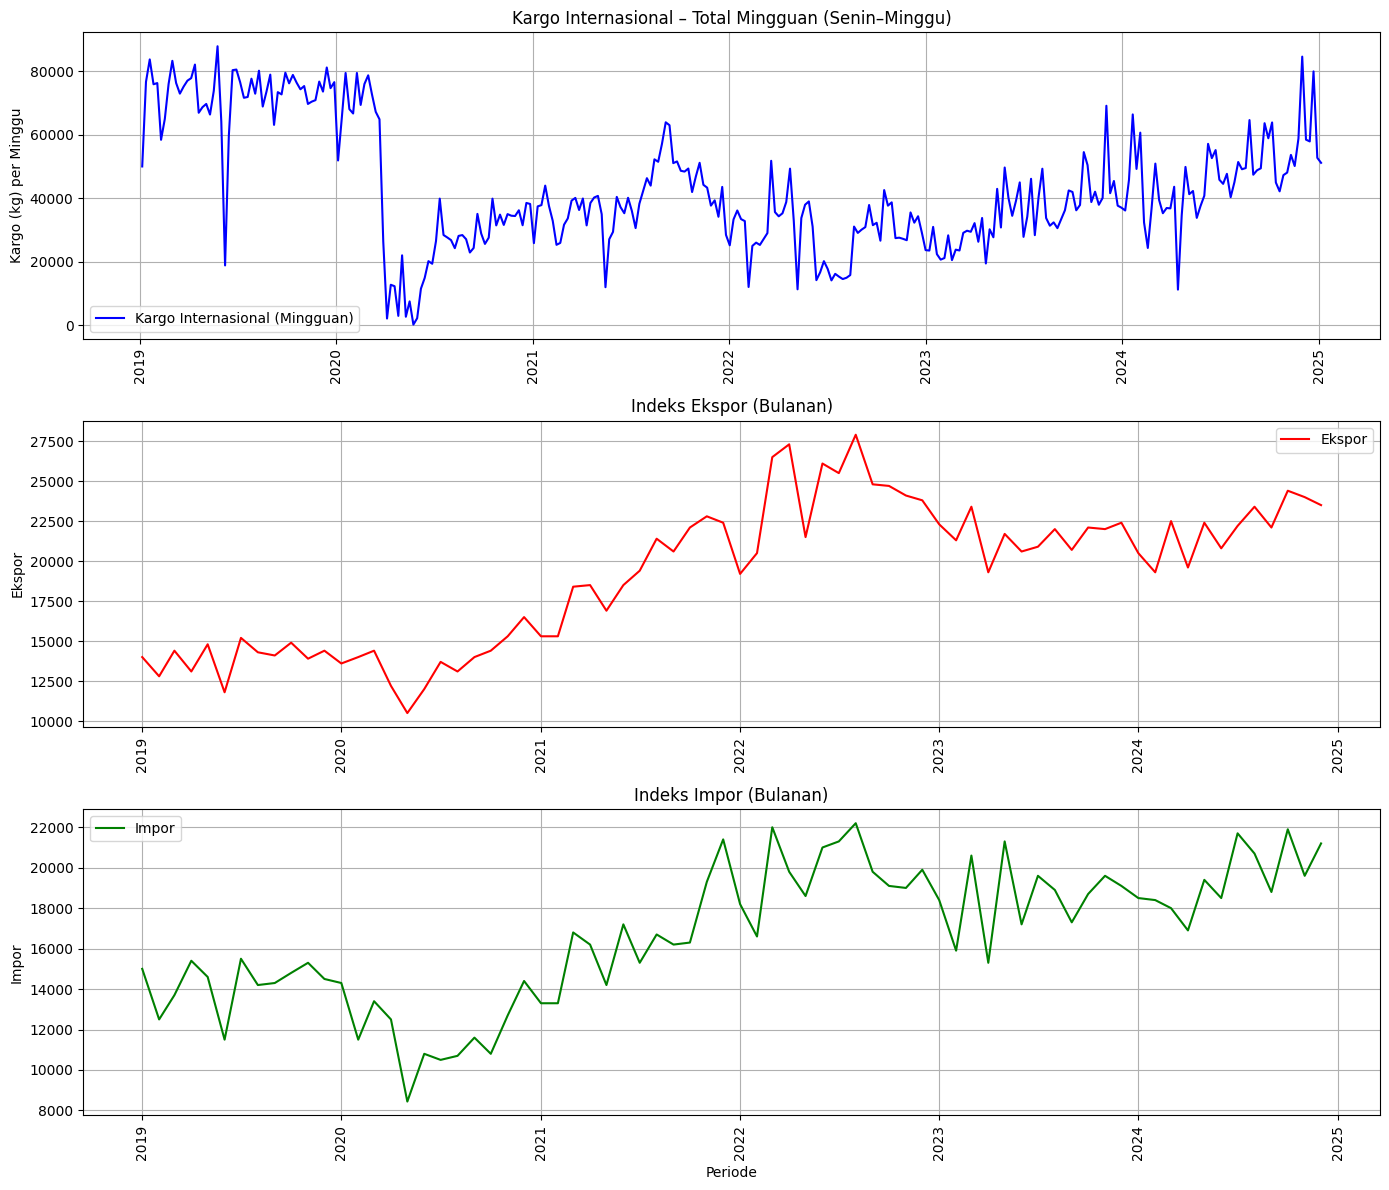

In [64]:

df_rekap["tanggal"] = pd.to_datetime(df_rekap["tanggal"])

# === KARGO MINGGUAN ===
# Definisi minggu: Senin–Minggu, label di hari Minggu (W-SUN)
weekly_kargo = (
    df_rekap.set_index("tanggal")["kargo (kg)_I"]
            .resample("W-SUN")  
            .mean()              
            .rename("kargo_mingguan")
)

# === PLOTTING 3 SUBPLOT ===
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=False)

# 1) Kargo Internasional (Mingguan)
axes[0].plot(weekly_kargo.index, weekly_kargo.values, label="Kargo Internasional (Mingguan)", color="blue")
axes[0].set_title("Kargo Internasional – Total Mingguan (Senin–Minggu)")
axes[0].set_ylabel("Kargo (kg) per Minggu")
axes[0].grid(True)
axes[0].legend()

# 2) Ekspor (bulanan, dari df_ie)
axes[1].plot(df_ie["Tanggal"], df_ie["Ekspor"], label="Ekspor", color="red")
axes[1].set_title("Indeks Ekspor (Bulanan)")
axes[1].set_ylabel("Ekspor")
axes[1].grid(True)
axes[1].legend()

# 3) Impor (bulanan, dari df_ie)
axes[2].plot(df_ie["Tanggal"], df_ie["Impor"], label="Impor", color="green")
axes[2].set_title("Indeks Impor (Bulanan)")
axes[2].set_ylabel("Impor")
axes[2].set_xlabel("Periode")
axes[2].grid(True)
axes[2].legend()

for ax in axes:
    ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()


In [65]:
df_ie["Tanggal"] = pd.to_datetime(df_ie["Tanggal"])
df_ie = df_ie.set_index("Tanggal").resample("M").mean().reset_index()


C:\Users\puguh\AppData\Local\Temp\ipykernel_18328\2983090634.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [66]:
kargo_bulanan = (
    df_rekap.set_index("tanggal")["kargo (kg)_I"]
            .resample("M").mean()
            .rename("Kargo_Internasional")
            .reset_index()
)


C:\Users\puguh\AppData\Local\Temp\ipykernel_18328\1634042994.py:3: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [67]:
df_merge = pd.merge(
    kargo_bulanan, df_ie,
    left_on="tanggal", right_on="Tanggal",
    how="inner"
)


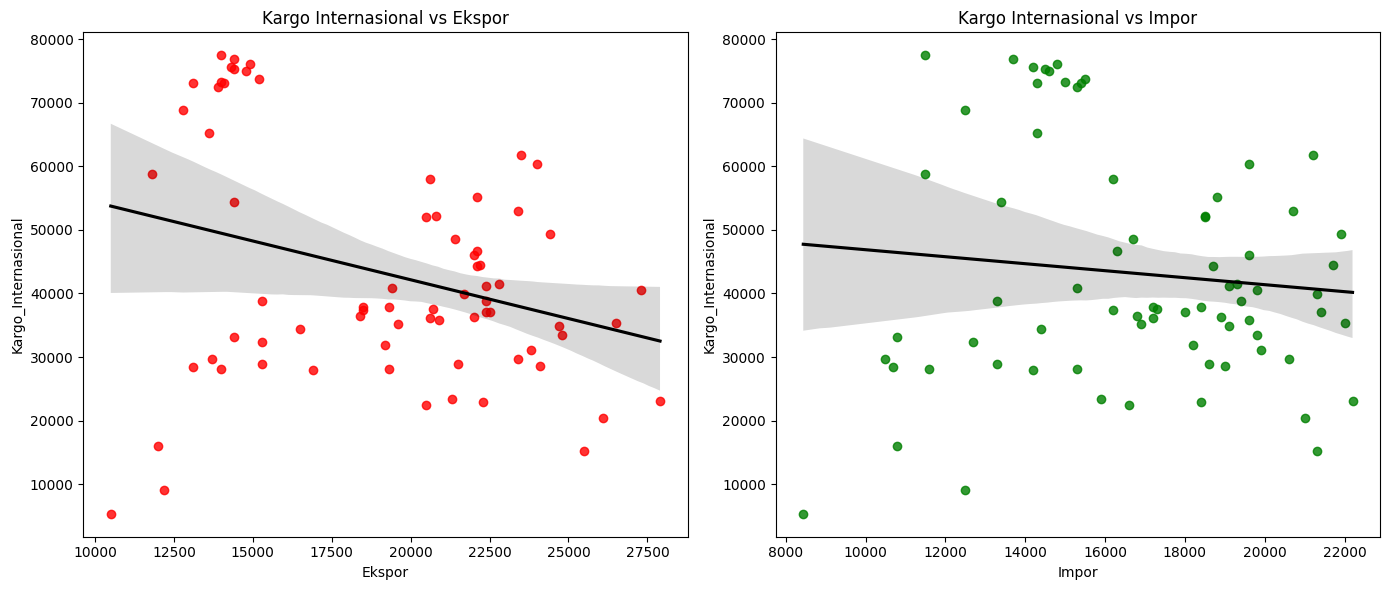

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.regplot(
    data=df_merge, x="Ekspor", y="Kargo_Internasional",
    ax=axes[0], color="red", line_kws={"color": "black"}
)
axes[0].set_title("Kargo Internasional vs Ekspor")

sns.regplot(
    data=df_merge, x="Impor", y="Kargo_Internasional",
    ax=axes[1], color="green", line_kws={"color": "black"}
)
axes[1].set_title("Kargo Internasional vs Impor")

plt.tight_layout()
plt.show()


In [69]:
df_var = pd.DataFrame({
    "Kargo": weekly_kargo.resample("M").mean(),   # atau langsung pakai kargo bulanan
    "Ekspor": df_ie.set_index("Tanggal")["Ekspor"].resample("M").mean(),
    "Impor": df_ie.set_index("Tanggal")["Impor"].resample("M").mean()
}).dropna()

print(df_var.head())

                   Kargo   Ekspor    Impor
2019-01-31  71628.785714  14000.0  15000.0
2019-02-28  68958.678571  12800.0  12500.0
2019-03-31  77010.514286  14400.0  13700.0
2019-04-30  73943.857143  13100.0  15400.0
2019-05-31  74496.535714  14800.0  14600.0


C:\Users\puguh\AppData\Local\Temp\ipykernel_18328\3558006488.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\puguh\AppData\Local\Temp\ipykernel_18328\3558006488.py:3: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\puguh\AppData\Local\Temp\ipykernel_18328\3558006488.py:4: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [70]:
from statsmodels.tsa.stattools import adfuller

for col in df_var.columns:
    result = adfuller(df_var[col])
    print(f"{col}: ADF={result[0]:.4f}, p-value={result[1]:.4f}")


Kargo: ADF=-2.4572, p-value=0.1263
Ekspor: ADF=-1.4546, p-value=0.5559
Impor: ADF=-0.9976, p-value=0.7542


In [71]:
from statsmodels.tsa.stattools import grangercausalitytests

print("Granger Test: Kargo ~ Ekspor")
grangercausalitytests(df_var[["Kargo","Ekspor"]].dropna(), maxlag=3)

print("Granger Test: Kargo ~ Impor")
grangercausalitytests(df_var[["Kargo","Impor"]].dropna(), maxlag=3)


Granger Test: Kargo ~ Ekspor

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2480  , p=0.6201  , df_denom=68, df_num=1
ssr based chi2 test:   chi2=0.2589  , p=0.6109  , df=1
likelihood ratio test: chi2=0.2584  , p=0.6112  , df=1
parameter F test:         F=0.2480  , p=0.6201  , df_denom=68, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2317  , p=0.7938  , df_denom=65, df_num=2
ssr based chi2 test:   chi2=0.4991  , p=0.7791  , df=2
likelihood ratio test: chi2=0.4973  , p=0.7798  , df=2
parameter F test:         F=0.2317  , p=0.7938  , df_denom=65, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0595  , p=0.9808  , df_denom=62, df_num=3
ssr based chi2 test:   chi2=0.1985  , p=0.9778  , df=3
likelihood ratio test: chi2=0.1982  , p=0.9779  , df=3
parameter F test:         F=0.0595  , p=0.9808  , df_denom=62, df_num=3
Granger Test: Kargo ~ Impor

Granger Causality
number of lags (no zero)

{1: ({'ssr_ftest': (0.06615207585445883, 0.7978007131270554, 68.0, 1),
   'ssr_chi2test': (0.06907054978921436, 0.7926948957582516, 1),
   'lrtest': (0.06903697479606308, 0.7927441379636402, 1),
   'params_ftest': (0.06615207593362994, 0.7978007130087351, 68.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.2263947811533973, 0.7980293587405617, 65.0, 2),
   'ssr_chi2test': (0.48761952863808655, 0.7836366957444443, 2),
   'lrtest': (0.4859289977391654, 0.7842993567910758, 2),
   'params_ftest': (0.22639478115338948, 0.7980293587405675, 65.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.13395131164936647, 0.9394637957328572, 62.0, 3),
   'ssr_chi2test': (0.44722454050675586, 0.9303231722842997, 3),
   'lrtest': (0.4457814265583693, 0.9306308994960465, 3),
   'params_ftest': (0.13395131164935684, 0.9394637957328631, 62.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0

# Analisis VAR & Granger Causality  
**Variabel**: Kargo Internasional, Ekspor, Impor (data bulanan)

---

## 1. Uji Stasioneritas (ADF Test)
- **Kargo**: ADF = -2.4572, p-value = 0.1263 → Tidak stasioner (p > 0.05)  
- **Ekspor**: ADF = -1.4546, p-value = 0.5559 → Tidak stasioner  
- **Impor**: ADF = -0.9976, p-value = 0.7542 → Tidak stasioner  

📌 Semua variabel non-stasioner → perlu differencing jika ingin dipakai di model VAR lebih lanjut.

---

## 2. Granger Causality Test

### Kargo → Ekspor
- Lag 1: p = 0.6201  
- Lag 2: p = 0.7938  
- Lag 3: p = 0.9808  
➡️ **Tidak signifikan**, artinya pergerakan Kargo tidak menjelaskan pergerakan Ekspor.

### Kargo → Impor
- Lag 1: p = 0.7978  
- Lag 2: p = 0.7980  
- Lag 3: p = 0.9395  
➡️ **Tidak signifikan**, artinya Kargo juga tidak menjelaskan pergerakan Impor.

---

## 3. Kesimpulan
- Baik **Ekspor** maupun **Impor** **tidak memiliki hubungan kausal jangka pendek** terhadap Kargo Internasional, begitu pula sebaliknya.  
- Korelasi visual yang lemah di scatter/regplot ternyata konsisten secara statistik.  
- Hal ini menunjukkan bahwa **pergerakan kargo internasional lebih dipengaruhi faktor lain**, misalnya:  
  - Permintaan global dan jalur logistik transit.  
  - Kebijakan transportasi udara kargo.  
  - Faktor eksternal (harga avtur, pandemi, supply chain global).


In [72]:
import statsmodels.api as sm

# === Kargo vs Ekspor ===
X = sm.add_constant(df_var["Ekspor"])  # variabel independen
y = df_var["Kargo"]                    # variabel dependen
model_ekspor = sm.OLS(y, X).fit()
print("R² Kargo ~ Ekspor:", model_ekspor.rsquared)

# === Kargo vs Impor ===
X = sm.add_constant(df_var["Impor"])
y = df_var["Kargo"]
model_impor = sm.OLS(y, X).fit()
print("R² Kargo ~ Impor:", model_impor.rsquared)

# === Kargo vs Ekspor+Impor (regresi berganda) ===
X = sm.add_constant(df_var[["Ekspor", "Impor"]])
y = df_var["Kargo"]
model_both = sm.OLS(y, X).fit()
print("R² Kargo ~ Ekspor+Impor:", model_both.rsquared)


R² Kargo ~ Ekspor: 0.09497726650458871
R² Kargo ~ Impor: 0.011441963921119291
R² Kargo ~ Ekspor+Impor: 0.2799960232687674


---

## 📌 Insight Utama
1. **Ekspor** hanya menjelaskan sekitar **9,5% variasi kargo internasional**.  
   - Artinya hubungan ada, tapi sangat lemah.  
2. **Impor** lebih lemah lagi, hanya **1,1%** → hampir tidak ada kontribusi langsung terhadap kargo internasional.  
3. Jika **Ekspor dan Impor digabung**, variasi kargo yang bisa dijelaskan naik menjadi **28%**.  
   - Masih tergolong rendah → artinya **72% variasi kargo internasional dipengaruhi faktor lain**.  

---

## FORECASTING

In [73]:
# Ambil kolom pax domestik dan internasional
df_fc = df_rekap[["tanggal", "total pax_D", "total pax_I"]].copy()

# Gabungkan (jumlah domestik + internasional) lalu bagi 2
df_fc["gabungan"] = (df_fc["total pax_D"] + df_fc["total pax_I"]) / 2



print(df_fc.head())


     tanggal  total pax_D  total pax_I  gabungan
0 2019-01-01        40269         8205   24237.0
1 2019-01-02        43837         7684   25760.5
2 2019-01-03        40886         9002   24944.0
3 2019-01-04        40812         6915   23863.5
4 2019-01-05        40041         6723   23382.0


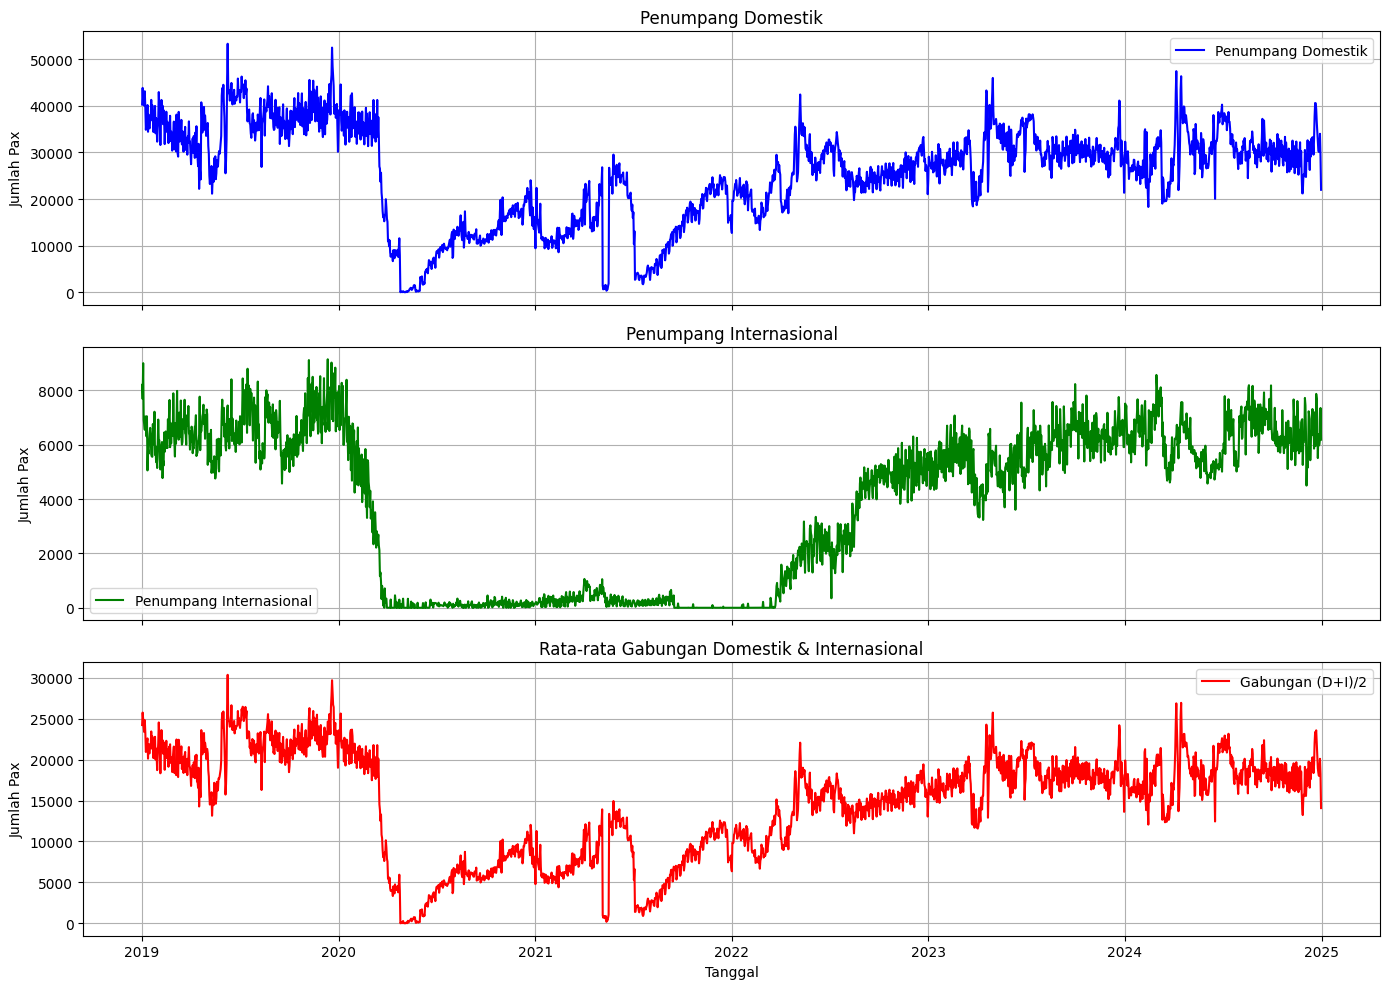

In [74]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# 1) Domestik
axes[0].plot(df_fc["tanggal"], df_fc["total pax_D"], color="blue", label="Penumpang Domestik")
axes[0].set_title("Penumpang Domestik")
axes[0].set_ylabel("Jumlah Pax")
axes[0].legend()
axes[0].grid(True)

# 2) Internasional
axes[1].plot(df_fc["tanggal"], df_fc["total pax_I"], color="green", label="Penumpang Internasional")
axes[1].set_title("Penumpang Internasional")
axes[1].set_ylabel("Jumlah Pax")
axes[1].legend()
axes[1].grid(True)

# 3) Gabungan
axes[2].plot(df_fc["tanggal"], df_fc["gabungan"], color="red", label="Gabungan (D+I)/2")
axes[2].set_title("Rata-rata Gabungan Domestik & Internasional")
axes[2].set_ylabel("Jumlah Pax")
axes[2].set_xlabel("Tanggal")
axes[2].legend()
axes[2].grid(True)


plt.tight_layout()
plt.show()


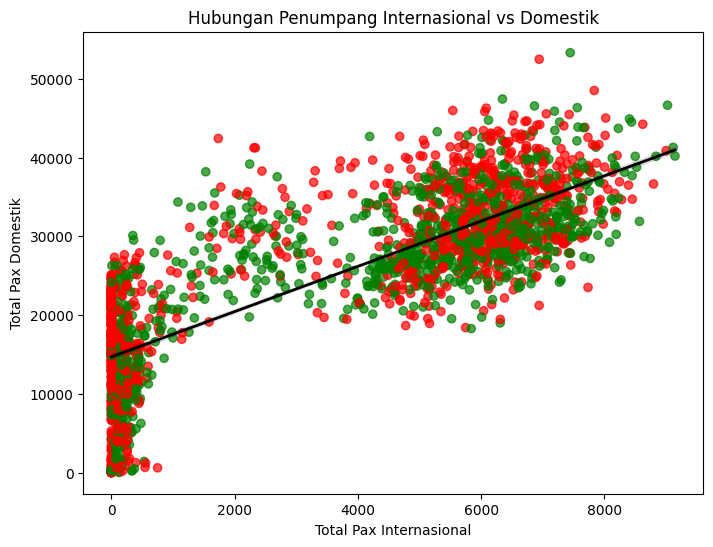

In [75]:
dx = df_fc["total pax_I"].diff()
dy = df_fc["total pax_D"].diff()

# Buat kategori warna
condition = np.sign(dx) == np.sign(dy)
colors = np.where(condition, "green", "red")

fig, ax = plt.subplots(figsize=(8, 6))

# Scatter dengan warna kondisi
ax.scatter(df_fc["total pax_I"], df_fc["total pax_D"], 
           c=colors, alpha=0.7, label="Titik data")

# Garis regresi
sns.regplot(
    data=df_fc,
    x="total pax_I", y="total pax_D",
    scatter=False,   
    ax=ax,
    color="black",   
    line_kws={"linewidth": 2}
)

ax.set_title("Hubungan Penumpang Internasional vs Domestik")
ax.set_xlabel("Total Pax Internasional")
ax.set_ylabel("Total Pax Domestik")
plt.show()

Titik hijau = x & y bergerak searah (naik-naik / turun-turun).

Titik merah = x & y bergerak berlawanan (satu naik, satu turun).

Garis hitam = regresi linear (trend keseluruhan).

In [76]:
X = sm.add_constant(df_fc["total pax_D"])  
y = df_fc["total pax_I"]                    
model_ekspor = sm.OLS(y, X).fit()
print("R² Domestik ~ Internasional:", model_ekspor.rsquared)
print(df_fc["total pax_D"].corr(df_fc["total pax_I"]))


R² Domestik ~ Internasional: 0.6431011568044789
0.8019358807314203


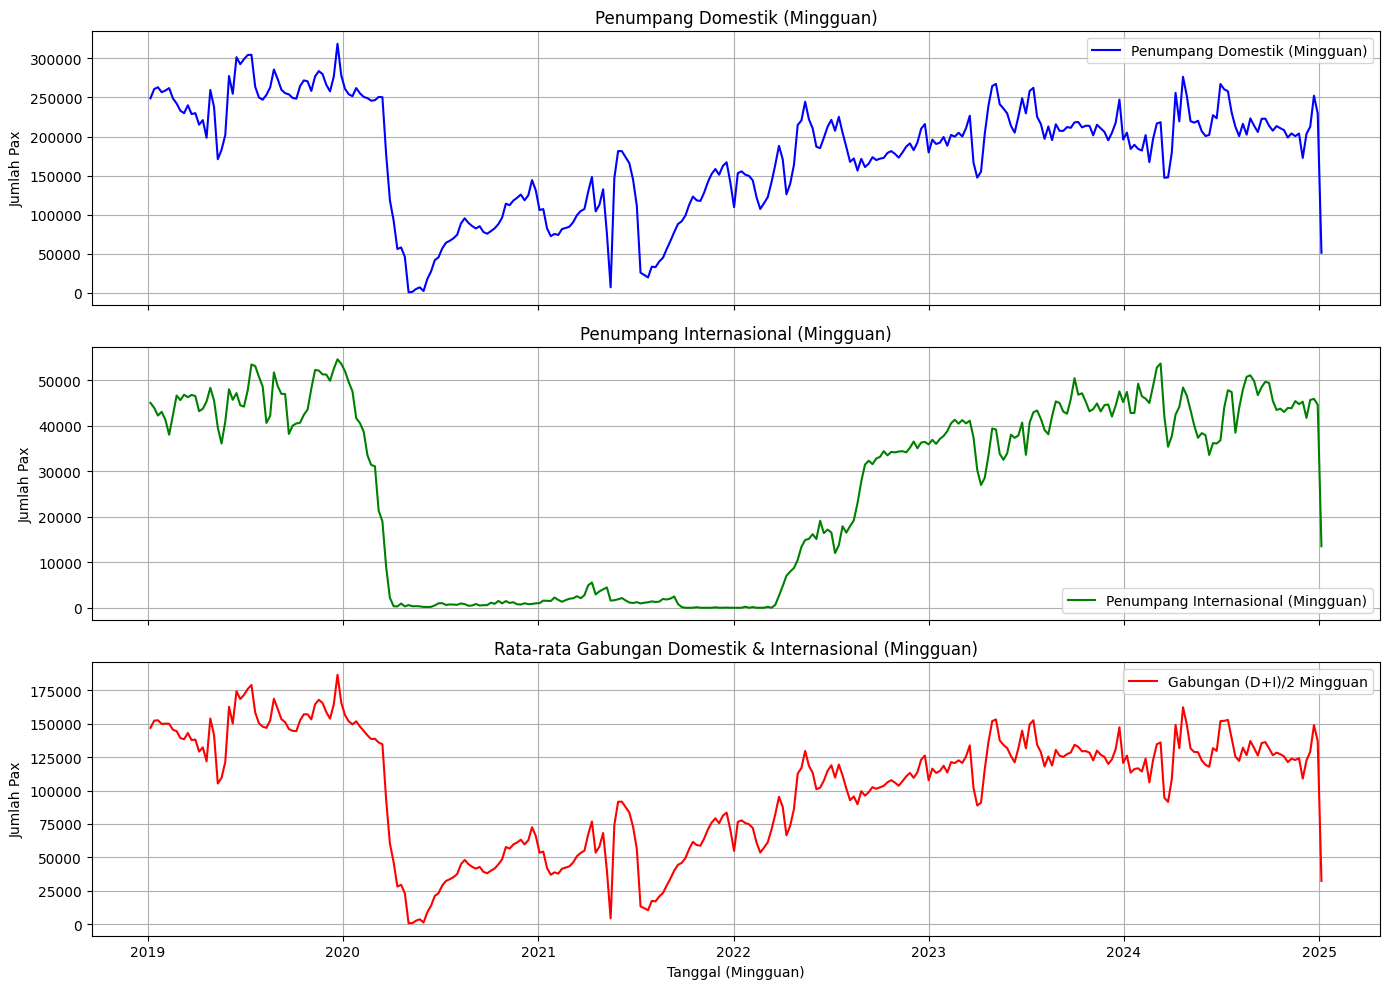

In [77]:
# pastikan kolom tanggal jadi datetime
df_fc["tanggal"] = pd.to_datetime(df_fc["tanggal"])

# set index tanggal
df_fc = df_fc.set_index("tanggal")

# --- Resample per minggu (pakai rata-rata, bisa juga sum) ---
weekly_D = df_fc["total pax_D"].resample("W-SUN").sum()
weekly_I = df_fc["total pax_I"].resample("W-SUN").sum()
weekly_gab = df_fc["gabungan"].resample("W-SUN").sum()

# --- Plot ---
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# 1) Domestik
axes[0].plot(weekly_D.index, weekly_D.values, color="blue", label="Penumpang Domestik (Mingguan)")
axes[0].set_title("Penumpang Domestik (Mingguan)")
axes[0].set_ylabel("Jumlah Pax")
axes[0].legend()
axes[0].grid(True)

# 2) Internasional
axes[1].plot(weekly_I.index, weekly_I.values, color="green", label="Penumpang Internasional (Mingguan)")
axes[1].set_title("Penumpang Internasional (Mingguan)")
axes[1].set_ylabel("Jumlah Pax")
axes[1].legend()
axes[1].grid(True)

# 3) Gabungan
axes[2].plot(weekly_gab.index, weekly_gab.values, color="red", label="Gabungan (D+I)/2 Mingguan")
axes[2].set_title("Rata-rata Gabungan Domestik & Internasional (Mingguan)")
axes[2].set_ylabel("Jumlah Pax")
axes[2].set_xlabel("Tanggal (Mingguan)")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
df_weekly = pd.DataFrame({
    "tanggal": weekly_gab.index,   
    "gabungan": weekly_gab.values
})
df_weekly["tanggal"] = pd.to_datetime(df_weekly["tanggal"])
df_weekly = df_weekly.set_index("tanggal")

print(df_weekly.head())


            gabungan
tanggal             
2019-01-06  147022.0
2019-01-13  152391.5
2019-01-20  152701.5
2019-01-27  149938.0
2019-02-03  150143.0


In [81]:
df_weekly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 314 entries, 2019-01-06 to 2025-01-05
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gabungan  314 non-null    float64
dtypes: float64(1)
memory usage: 4.9 KB


In [82]:
ts=df_weekly["gabungan"]

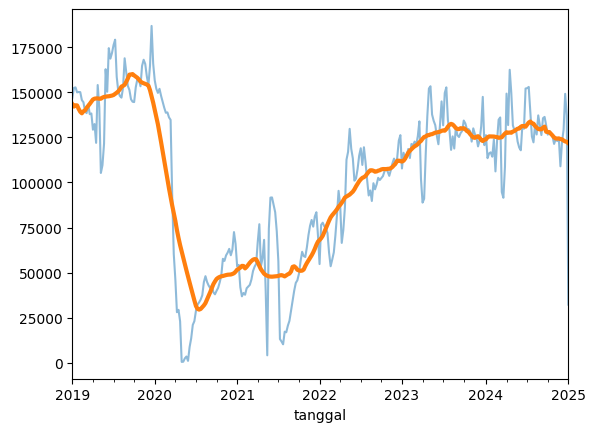

In [83]:
trend = ts.rolling(
    window=30,
    center=True,
    min_periods=15
).mean()

ax = ts.plot(alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

<Axes: >

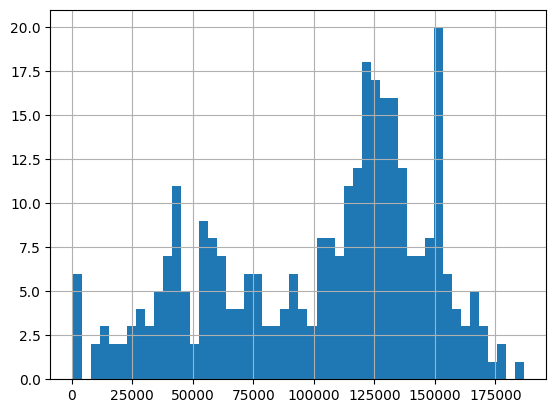

In [86]:
df_weekly.gabungan.hist(bins=50)


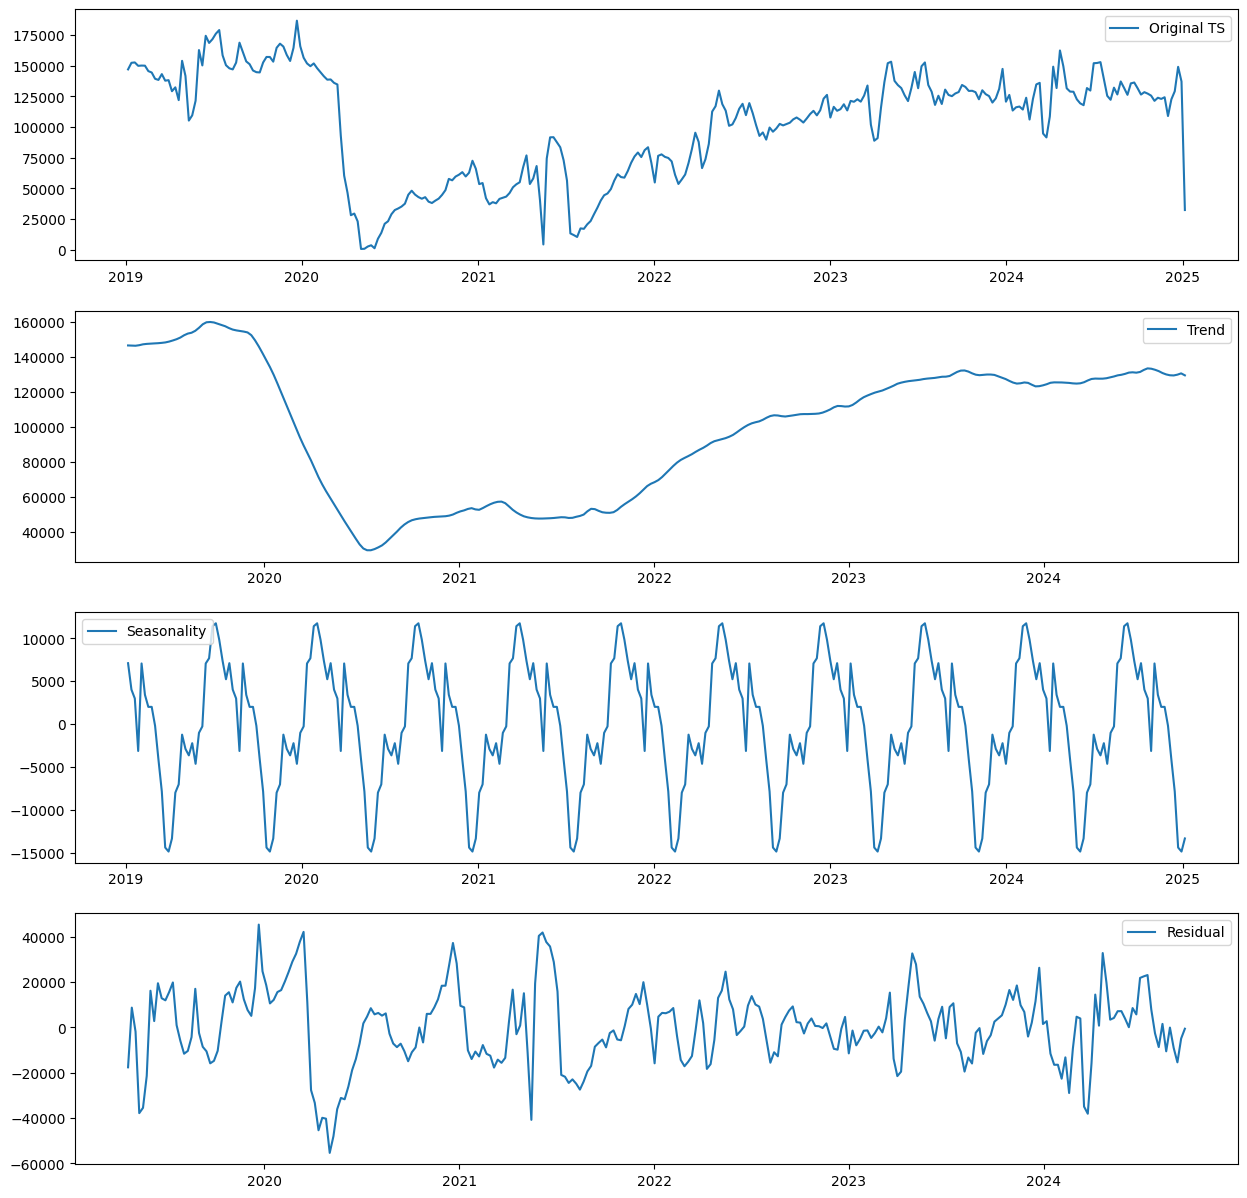

In [91]:
decompose_add=seasonal_decompose(df_weekly['gabungan'], model='additive', period=30)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(df_weekly['gabungan'], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

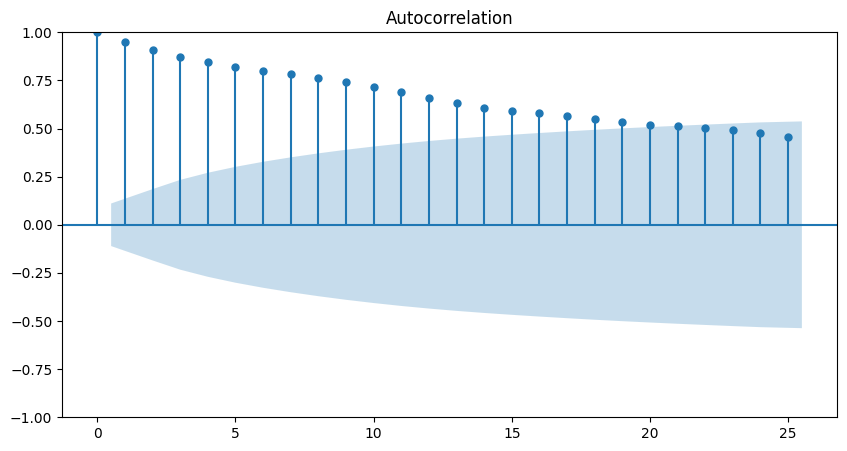

In [92]:
plt.rc("figure", figsize=(10,5))
plot_acf(df_weekly['gabungan'])
print()

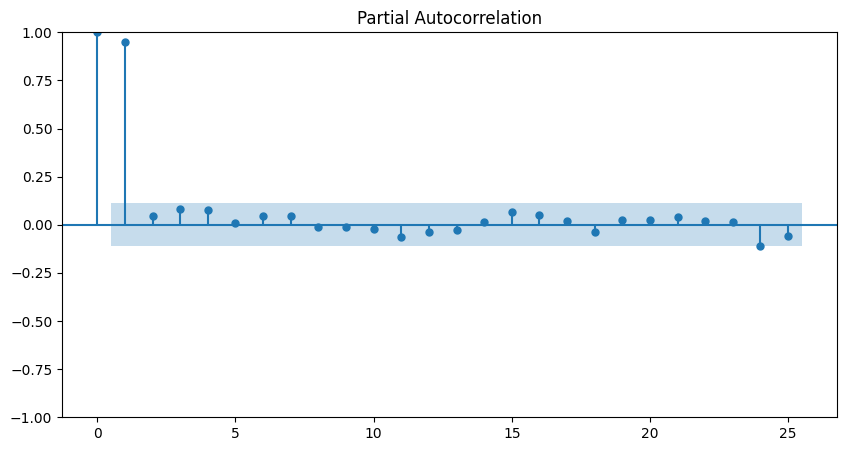

In [93]:
plt.rc("figure", figsize=(10,5))
plot_pacf(df_weekly['gabungan'])
print()

In [94]:
split_idx = int(0.8 * len(ts))
ts_train = ts[:split_idx]
ts_test= ts[split_idx:]

In [95]:
scaler = MinMaxScaler()
ts_train = scaler.fit_transform(ts_train.values.reshape(-1, 1))
ts_test = scaler.transform(ts_test.values.reshape(-1, 1))

In [96]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [97]:
seq_length = 5
X_train, y_train = create_sequences(ts_train, seq_length)
X_test, y_test = create_sequences(ts_test, seq_length)

In [98]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(246, 5, 1) (246, 1)
(58, 5, 1) (58, 1)


In [99]:
model = Sequential([
    Input(shape=(seq_length, 1)),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [100]:
callback = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=64,
    validation_split=0.1,
    callbacks=[callback],
    verbose=1
)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.2530 - val_loss: 0.2558
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1126 - val_loss: 0.0528
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0226 - val_loss: 0.0258
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0455 - val_loss: 0.0130
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0215 - val_loss: 0.0135
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0209 - val_loss: 0.0334
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0236 - val_loss: 0.0229
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0165 - val_loss: 0.0069
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0143 - val_loss: 0.0059
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0167 - val_loss: 0.0052
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0140 - val_loss: 0.0072
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0133 - val_l

In [101]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [102]:
def evaluate(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    return mse, rmse, mae

In [103]:
train_mse, train_rmse, train_mae = evaluate(y_train_orig, train_pred)
test_mse, test_rmse, test_mae = evaluate(y_test_orig, test_pred)

print(f"Test RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, MSE: {train_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, MSE: {test_mse:.4f}")

Test RMSE: 20994.5251, MAE: 14539.4302, MSE: 440770085.8974
Test RMSE: 19987.8631, MAE: 13845.0323, MSE: 399514669.9547


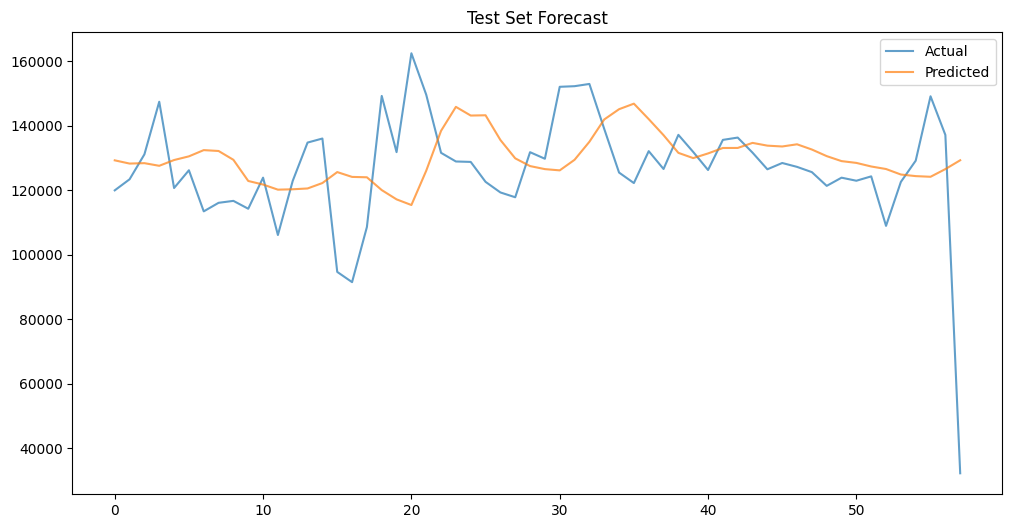

In [104]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig, label='Actual', alpha=0.7)
plt.plot(test_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.title("Test Set Forecast")
plt.show()

In [105]:
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape=(seq_length, 1)),
    LSTM(100, return_sequences=True,),
    Dropout(0.2),
    LSTM(100,),
    Dropout(0.2),
    Dense(100),
    Dropout(0.2),
    Dense(25),
    Dense(1),
])
opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=opt1, loss='mse')

In [106]:
callback = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=64,
    validation_split=0.1,
    callbacks=[callback],
    verbose=1
)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 0.2095 - val_loss: 0.0715
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0335 - val_loss: 0.0335
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0462 - val_loss: 0.0100
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0261 - val_loss: 0.0492
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0346 - val_loss: 0.0238
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0205 - val_loss: 0.0045
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0191 - val_loss: 0.0048
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0188 - val_loss: 0.0093
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0156 - val_loss: 0.0142
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0156 - val_loss: 0.0060
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0145 - val_loss: 0.0059
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0148 - val_l

In [107]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [108]:
train_mse, train_rmse, train_mae = evaluate(y_train_orig, train_pred)
test_mse, test_rmse, test_mae = evaluate(y_test_orig, test_pred)

print(f"Train RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, MSE: {train_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, MSE: {test_mse:.4f}")

Train RMSE: 23500.7037, MAE: 16985.8441, MSE: 552283075.1615
Test RMSE: 19320.4969, MAE: 12848.2508, MSE: 373281600.0783


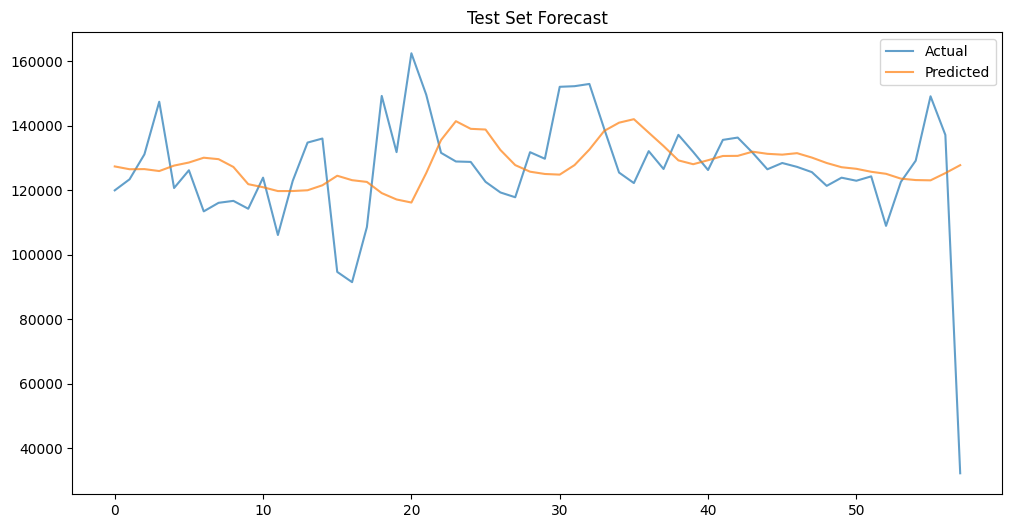

In [109]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig, label='Actual', alpha=0.7)
plt.plot(test_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.title("Test Set Forecast")
plt.show()

## Bidirectional LSTM


In [110]:
from tensorflow.keras.layers import Bidirectional
model = Sequential([
    Input(shape=(seq_length, 1)),
    Bidirectional(LSTM(200, return_sequences=True,)),
    Dropout(0.2),
    Bidirectional(LSTM(100,)),
    Dropout(0.2),
    Dense(100),
    Dropout(0.2),
    Dense(25),
    Dense(1),
])
model.compile(optimizer='adam', loss='mse')

In [111]:
callback = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=64,
    validation_split=0.1,
    callbacks=[callback],
    verbose=1
)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 0.1630 - val_loss: 0.0529
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0568 - val_loss: 0.0057
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0253 - val_loss: 0.0664
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0354 - val_loss: 0.0118
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0154 - val_loss: 0.0105
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0194 - val_loss: 0.0041
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0143 - val_loss: 0.0130
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0149 - val_loss: 0.0087
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0122 - val_loss: 0.0042
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0118 - val_loss: 0.0041
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0107 - val_loss: 0.0050
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0100 - val_l

In [112]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [113]:
train_mse, train_rmse, train_mae = evaluate(y_train_orig, train_pred)
test_mse, test_rmse, test_mae = evaluate(y_test_orig, test_pred)

print(f"Train RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, MSE: {train_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, MSE: {test_mse:.4f}")

Train RMSE: 18813.0201, MAE: 12739.7752, MSE: 353929724.8748
Test RMSE: 19179.0814, MAE: 12430.6820, MSE: 367837163.5403


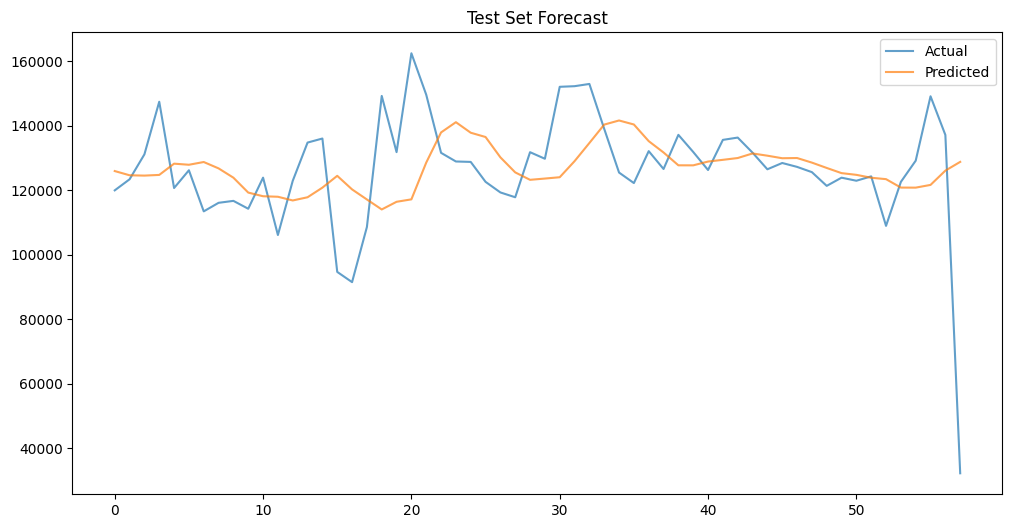

In [114]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig, label='Actual', alpha=0.7)
plt.plot(test_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.title("Test Set Forecast")
plt.show()

In [115]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test_orig, test_pred)
print("R²:", r2)

R²: -0.10756060489673036


## Peophle LSTM

In [116]:
class PeepholeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, return_sequences=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.return_sequences = return_sequences
        
        # Gate weights (input, forget, cell, output)
        self.weight_ih = nn.Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.Tensor(4 * hidden_size, hidden_size))
        
        # Peephole connections weights (input, forget, output)
        self.weight_pi = nn.Parameter(torch.Tensor(hidden_size))
        self.weight_pf = nn.Parameter(torch.Tensor(hidden_size))
        self.weight_po = nn.Parameter(torch.Tensor(hidden_size))
        
        # Biases
        self.bias = nn.Parameter(torch.Tensor(4 * hidden_size))
        
        self.init_parameters()

    def init_parameters(self):
        stdv = 1.0 / (self.hidden_size ** 0.5)
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        batch_size, seq_length, _ = x.size()
        
        # Initialize hidden state and cell state
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        
        outputs = []
        
        for t in range(seq_length):
            x_t = x[:, t, :]
            
            # Linear transformations
            gates = (x_t @ self.weight_ih.t() + self.bias +
                     h_t @ self.weight_hh.t())
            
            # Split gates
            i_t, f_t, g_t, o_t = gates.chunk(4, 1)
            
            # Apply peephole connections
            i_t = i_t + c_t * self.weight_pi
            f_t = f_t + c_t * self.weight_pf
            
            # Activation functions
            i_t = torch.sigmoid(i_t)
            f_t = torch.sigmoid(f_t)
            g_t = torch.tanh(g_t)
            
            # Update cell state
            c_t = f_t * c_t + i_t * g_t
            
            # Output gate with peephole
            o_t = o_t + c_t * self.weight_po
            o_t = torch.sigmoid(o_t)
            
            # Update hidden state
            h_t = o_t * torch.tanh(c_t)
            
            if self.return_sequences:
                outputs.append(h_t)
        
        if self.return_sequences:
            # Stack all hidden states
            return torch.stack(outputs, dim=1)
        else:
            # Return only the last hidden state
            return h_t

class LSTMModel(nn.Module):
    def __init__(self, seq_length, input_size=1):
        super().__init__()
        self.lstm1 = PeepholeLSTM(input_size, 100, return_sequences=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = PeepholeLSTM(100, 100, return_sequences=False)
        self.dropout2 = nn.Dropout(0.2)
        self.dense1 = nn.Linear(100, 100)
        self.dropout3 = nn.Dropout(0.2)
        self.dense2 = nn.Linear(100, 25)
        self.output = nn.Linear(25, 1)
        
    def forward(self, x):
        # Input shape: (batch_size, seq_length, input_size)
        x = self.lstm1(x)
        x = self.dropout1(x)
        x = self.lstm2(x)
        x = self.dropout2(x)
        x = torch.relu(self.dense1(x))
        x = self.dropout3(x)
        x = torch.relu(self.dense2(x))
        return self.output(x)

In [117]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# 1. Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# 2. Create validation split (15% of training data)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.15, random_state=42
)

# 3. Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_split, y_train_split)
val_dataset = TensorDataset(X_val_split, y_val_split)
test_dataset = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 5. Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(seq_length=X_train.shape[1]).to(device)
criterion = nn.MSELoss()  # Use appropriate loss for your task
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 6. Training with early stopping
epochs = 200
patience = 15
best_val_loss = float('inf')
counter = 0

train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    
    # Calculate epoch losses
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# 7. Load best model for predictions
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# 8. Make predictions on test data
test_predictions = []
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to(device)
        outputs = model(inputs)
        test_predictions.append(outputs.cpu().numpy())

test_predictions = np.vstack(test_predictions)

# 9. Convert to 1D array if needed
if test_predictions.shape[1] == 1:
    test_predictions = test_predictions.flatten()

print("Test predictions shape:", test_predictions.shape)

Epoch 1/200 | Train Loss: 0.509844 | Val Loss: 0.548496
Epoch 2/200 | Train Loss: 0.447671 | Val Loss: 0.474342
Epoch 3/200 | Train Loss: 0.376181 | Val Loss: 0.368647
Epoch 4/200 | Train Loss: 0.262944 | Val Loss: 0.177216
Epoch 5/200 | Train Loss: 0.097418 | Val Loss: 0.052386
Epoch 6/200 | Train Loss: 0.087192 | Val Loss: 0.038480
Epoch 7/200 | Train Loss: 0.049517 | Val Loss: 0.057731
Epoch 8/200 | Train Loss: 0.050971 | Val Loss: 0.059169
Epoch 9/200 | Train Loss: 0.047541 | Val Loss: 0.035446
Epoch 10/200 | Train Loss: 0.040945 | Val Loss: 0.030041
Epoch 11/200 | Train Loss: 0.038856 | Val Loss: 0.028582
Epoch 12/200 | Train Loss: 0.029718 | Val Loss: 0.030972
Epoch 13/200 | Train Loss: 0.029077 | Val Loss: 0.025072
Epoch 14/200 | Train Loss: 0.026311 | Val Loss: 0.018981
Epoch 15/200 | Train Loss: 0.024675 | Val Loss: 0.018849
Epoch 16/200 | Train Loss: 0.018937 | Val Loss: 0.023993
Epoch 17/200 | Train Loss: 0.021261 | Val Loss: 0.015056
Epoch 18/200 | Train Loss: 0.017129 | Va

In [118]:
test_pred = test_predictions.reshape(-1, 1)
test_pred = scaler.inverse_transform(test_pred)

In [119]:
test_mse, test_rmse, test_mae = evaluate(y_test_orig, test_pred)

print(f"Test RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, MSE: {test_mse:.4f}")

Test RMSE: 19452.8902, MAE: 11103.2396, MSE: 378414937.6070


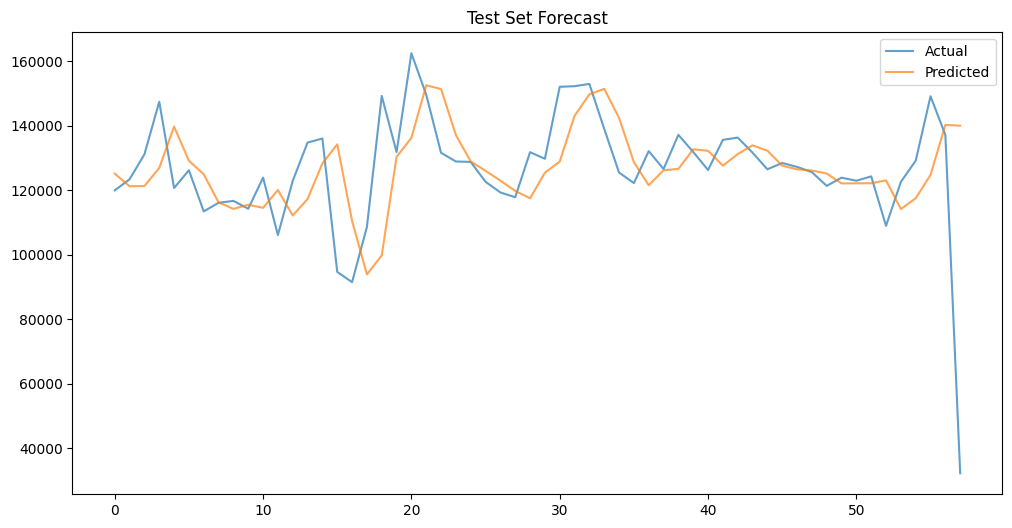

In [120]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig, label='Actual', alpha=0.7)
plt.plot(test_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.title("Test Set Forecast")
plt.show()

In [131]:
train_pred_1d = np.asarray(train_pred).ravel()
test_pred_1d  = np.asarray(test_pred).ravel()
y_train_1d    = np.asarray(y_train_orig).ravel()
y_test_1d     = np.asarray(y_test_orig).ravel()

# 2) gabung aktual penuh
y_all = np.concatenate([y_train_1d, y_test_1d])

# 3) look_back otomatis dari X_train
look_back = X_train.shape[1]

# 4) buffer prediksi penuh
full_pred = np.full(y_all.shape[0], np.nan, dtype=float)

# 5) tempatkan prediksi TRAIN (selalu mulai di look_back)
full_pred[look_back : look_back + len(train_pred_1d)] = train_pred_1d

In [132]:
start_test_A = len(y_train_1d)
#    - Opsi B (window→split): mulai setelah train + look_back
start_test_B = len(y_train_1d) + look_back

# 7) pilih yang muat sempurna
if start_test_A + len(test_pred_1d) <= len(y_all):
    start_test = start_test_A
elif start_test_B + len(test_pred_1d) <= len(y_all):
    start_test = start_test_B
else:
    # fallback: potong agar tidak overflow
    start_test = min(start_test_A, start_test_B)
    test_pred_1d = test_pred_1d[: max(0, len(y_all) - start_test)]

# 8) tempatkan prediksi TEST
full_pred[start_test : start_test + len(test_pred_1d)] = test_pred_1d

In [133]:
mask = ~np.isnan(full_pred)
rmse_all = mean_squared_error(y_all[mask], full_pred[mask], squared=False)
mae_all  = mean_absolute_error(y_all[mask], full_pred[mask])
print(f"Overall RMSE: {rmse_all:.4f}, MAE: {mae_all:.4f}")

Overall RMSE: 27082.7355, MAE: 16880.7041


C:\Users\puguh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



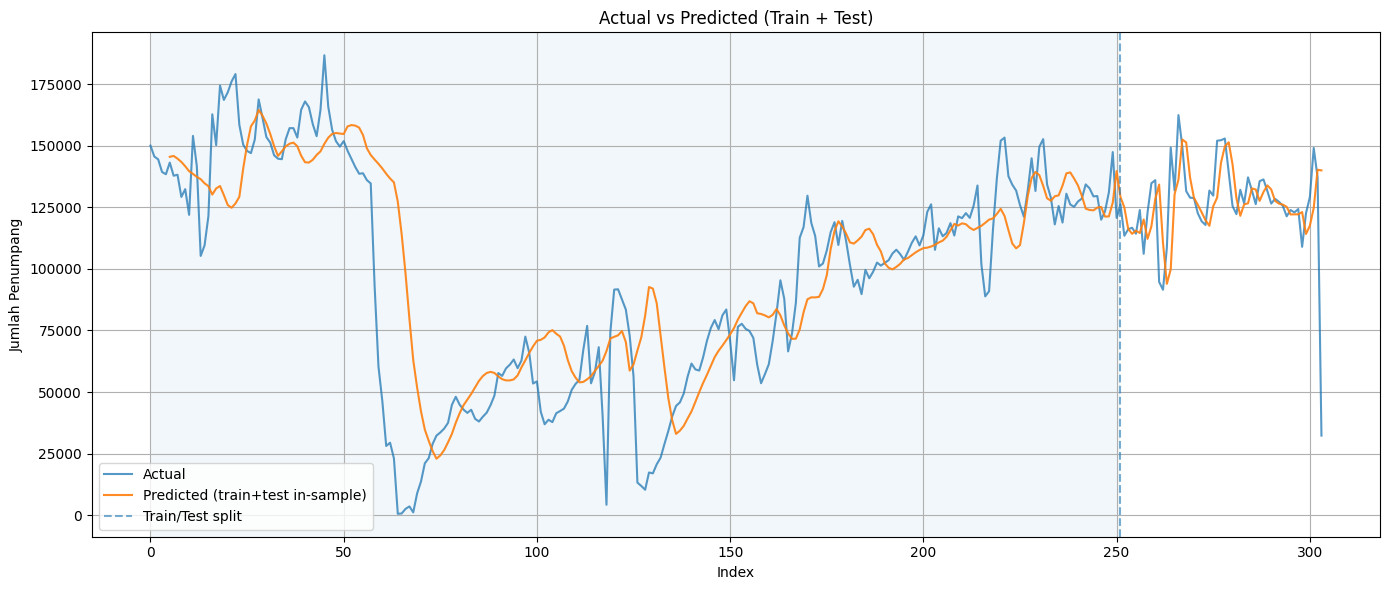

In [146]:
df_fit = pd.DataFrame({
    "Actual": y_all,
    "Predicted": full_pred
})
plt.figure(figsize=(14,6))
plt.plot(df_fit.index, df_fit["Actual"].values,    label="Actual", alpha=0.75)
plt.plot(df_fit.index, df_fit["Predicted"].values, label="Predicted (train+test in-sample)", alpha=0.9)

# Garis vertikal batas train/test + shading area train
plt.axvline(x=split_idx, linestyle="--", alpha=0.6, label="Train/Test split")
plt.axvspan(0, split_idx, alpha=0.06)

plt.title("Actual vs Predicted (Train + Test)")
plt.xlabel("Index" if not isinstance(df_fit.index, (pd.DatetimeIndex)) else "Tanggal")
plt.ylabel("Jumlah Penumpang")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [150]:
look_back = X_train.shape[1]
N = len(df_weekly.index)
M = len(y_all)
diff = N - M

if diff == look_back:
    idx_target = df_weekly.index[look_back:]           # window→split
elif diff == 2 * look_back:
    idx_target = df_weekly.index[look_back:-look_back] # split→window
else:
    idx_target = df_weekly.index[-M:]                  # fallback aman

hist_series = pd.Series(y_all, index=idx_target, name="Actual")

# (opsional) cek cepat
assert len(hist_series) == len(y_all)
assert isinstance(hist_series.index, pd.DatetimeIndex)

In [151]:
n_future_steps = 52
device = next(model.parameters()).device  # cpu / cuda

# gunakan data terakhir (scaled) sepanjang look_back sebagai window awal
y_all_scaled = scaler.transform(y_all.reshape(-1,1)).ravel()
window = y_all_scaled[-look_back:].reshape(1, look_back, 1)
window = torch.tensor(window, dtype=torch.float32, device=device)

future_scaled = []
model.eval()
with torch.no_grad():
    for _ in range(n_future_steps):
        yhat_scaled = model(window).detach().cpu().item()
        future_scaled.append(yhat_scaled)
        window = torch.roll(window, shifts=-1, dims=1)
        window[0, -1, 0] = yhat_scaled

# balik skala ke original
future = scaler.inverse_transform(np.array(future_scaled).reshape(-1,1)).ravel()

# index tanggal forecast (lanjut dari histori mingguan W-SUN)
start_date = hist_series.index[-1] + pd.offsets.Week(1)
future_index = pd.date_range(start=start_date, periods=n_future_steps, freq="W-SUN")
future_series = pd.Series(future, index=future_index, name="Forecast")

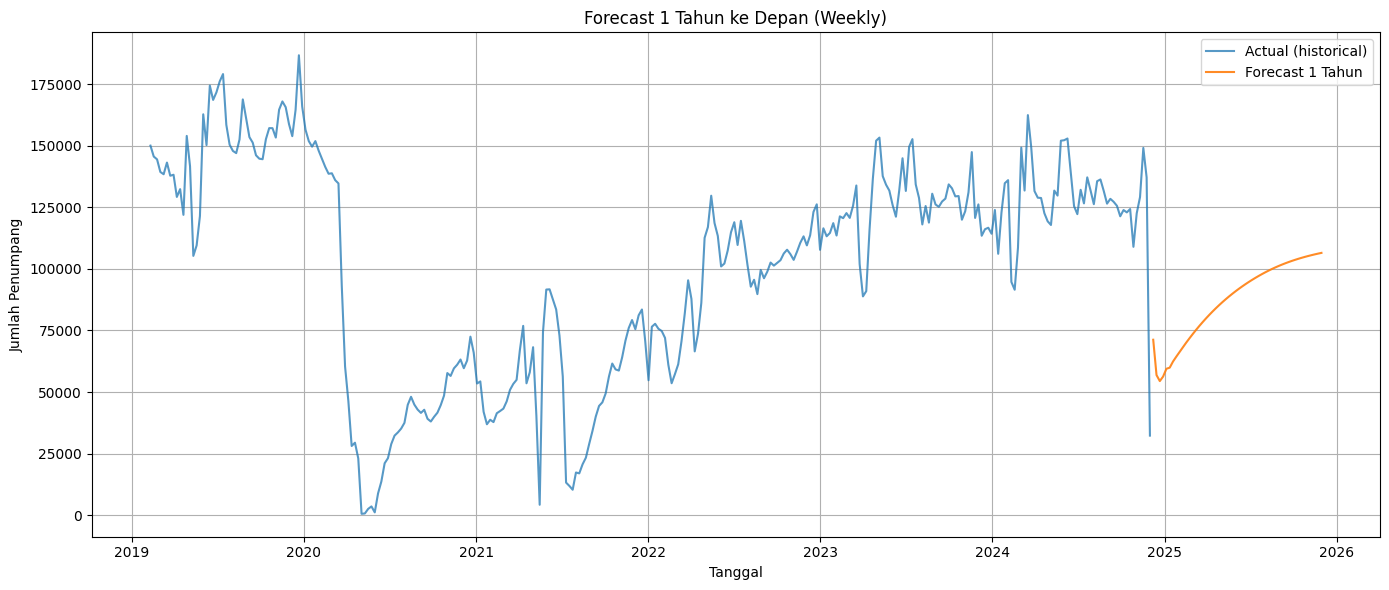

Ringkasan 5 bulan pertama (SUM per bulan):
2024-12-01    238821.515578
2025-01-01    246078.919665
2025-02-01    276321.560647
2025-03-01    383953.182895
2025-04-01    333355.305672
Freq: MS, Name: Forecast, dtype: float64


In [ ]:
plt.figure(figsize=(14,6))
plt.plot(hist_series.index,  hist_series.values,  label="Actual (historical)", alpha=0.75)
plt.plot(future_series.index, future_series.values, label="Forecast 1 Tahun", alpha=0.9)
plt.title("Forecast 1 Tahun ke Depan (Weekly)")
plt.xlabel("Tanggal"); plt.ylabel("Jumlah Penumpang")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


future_monthly = future_series.resample('MS').sum()
print("Ringkasan 5 bulan pertama (SUM per bulan):")
print(future_monthly.head())


## Anomali